## 0. Data Import

In [258]:
#uncomment to download required packages
#!pip install -r requirements.txt


In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
%config InlineBackend.figure_format = 'retina'

In [260]:
tesla_df = pd.read_csv('QRM-2025-cw2-data.csv')
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
#compute the log returns in %
tesla_df['log_returns'] = 100*(np.log(tesla_df.TSLA.shift(1)) - np.log(tesla_df.TSLA))
tesla_df['loss'] = -tesla_df.log_returns

In [261]:
tesla_df.head()

,Date,TSLA,log_returns,loss
0,2012-11-26,2.151333,NaN,NaN
1,2012-11-27,2.143333,0.372556,-0.372556
2,2012-11-28,2.215333,-3.304064,3.304064
3,2012-11-29,2.246000,-1.374813,1.374813
4,2012-11-30,2.254667,-0.385143,0.385143


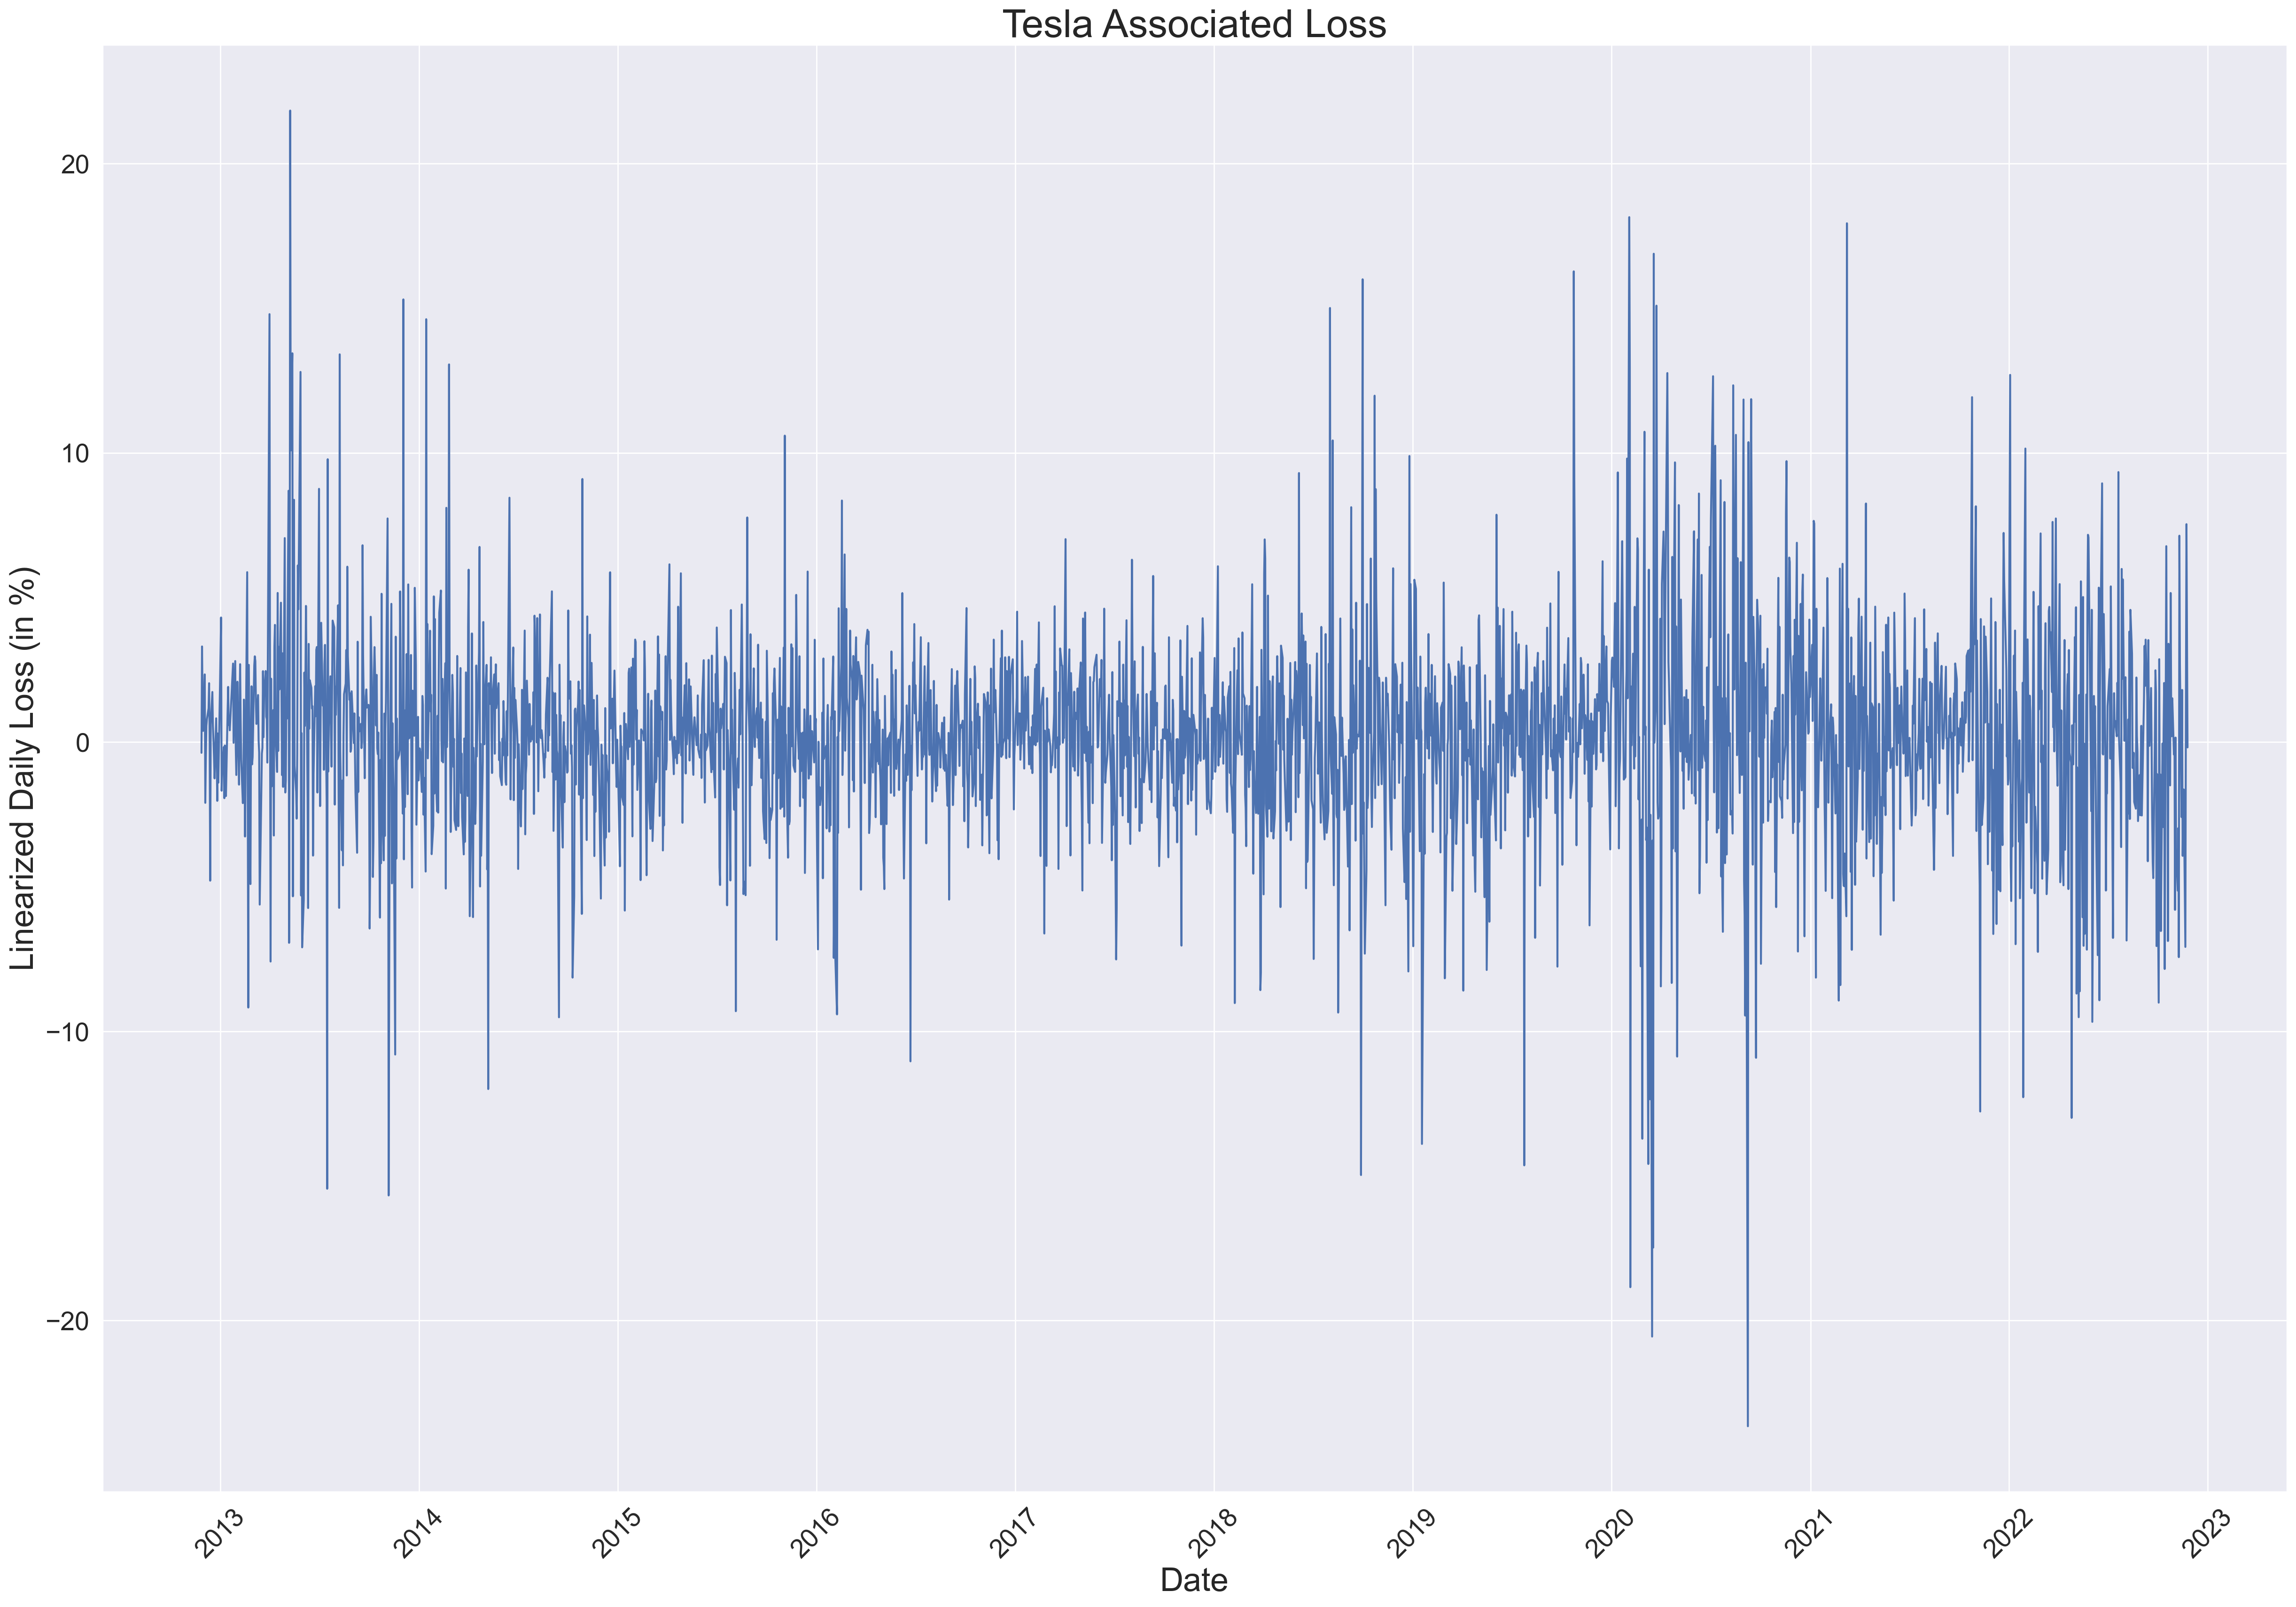

In [262]:
sns.set_theme()
plt.figure(figsize=(30, 20))
sns.lineplot(data=tesla_df, x='Date', y='loss', )
ax = plt.gca()
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.tick_params(axis='x', labelsize=20, labelrotation=45) # Pour l'axe X, avec une rotation
ax.tick_params(axis='y', labelsize=20) # Pour l'axe Y
plt.title("Tesla Associated Loss", fontsize=30)
plt.ylabel("Linearized Daily Loss (in %)", fontsize=25)
plt.xlabel("Date", fontsize=25)

plt.show()

--- 
## 1. Modeling on Training Data only 

In [263]:
train_df = tesla_df.loc[tesla_df.Date<'2021-11-26',:].dropna()
test_df = tesla_df.loc[tesla_df.Date>'2021-11-26',:].dropna()

### Fit a GARCH(1,1) model to the loss

In [264]:
GARCH = arch_model(train_df['loss'], mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = GARCH.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109977.43472223838
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948143837401
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970834915617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.87203617076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501525208385
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248120761451
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7993379015425
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.344203611621
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254442988
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119616166
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900442
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

In [265]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Tue, Dec 02 2025   Df Residuals:                     2265
Time:                        17:14:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1506  6.416e-02      2.347  1.891e-02 [2.485e-0

In [266]:
res.std_resid

1      -0.285321
2       1.725954
3       0.635442
4       0.121604
5       1.142008
          ...   
2262    0.130877
2263    0.891654
2264    0.404564
2265   -1.143070
2266    0.123682
Name: std_resid, Length: 2266, dtype: float64

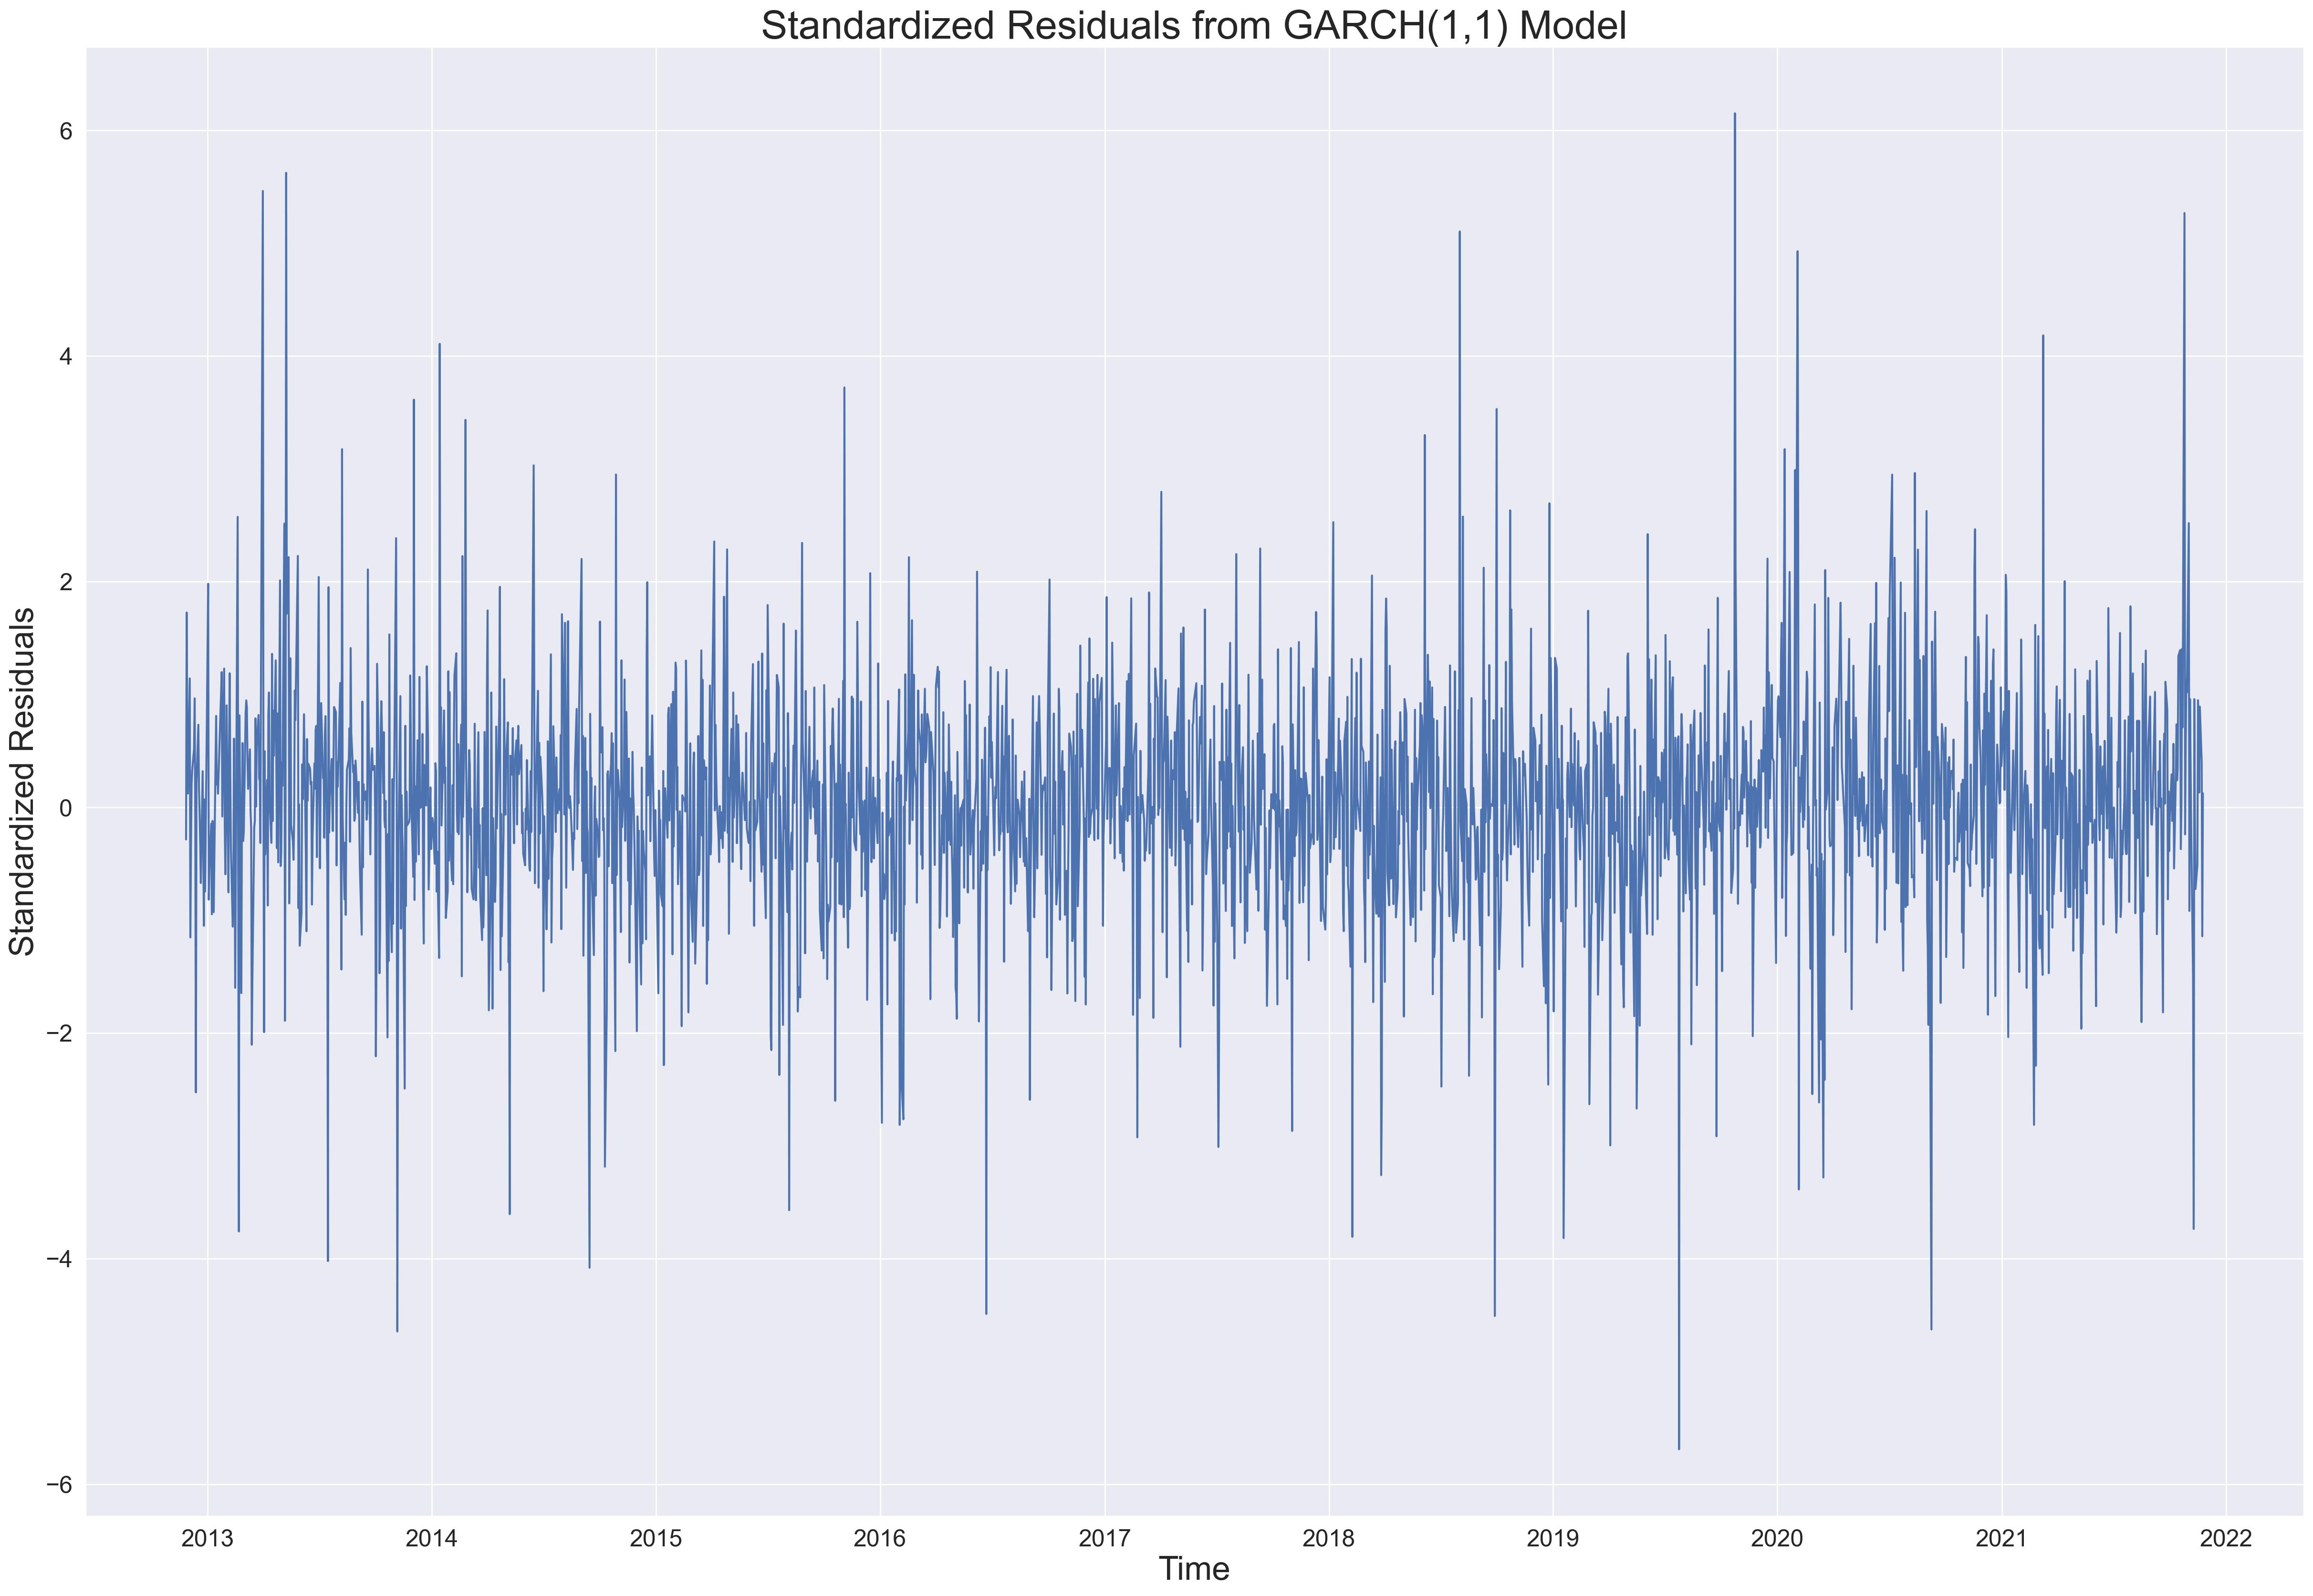

In [267]:
standardized_resid = res.std_resid

plt.figure(figsize=(30, 20))
sns.lineplot(x=train_df.Date, y=standardized_resid)
plt.title("Standardized Residuals from GARCH(1,1) Model", fontsize=30)
plt.ylabel("Standardized Residuals", fontsize=25)
plt.xlabel("Time", fontsize=25)
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

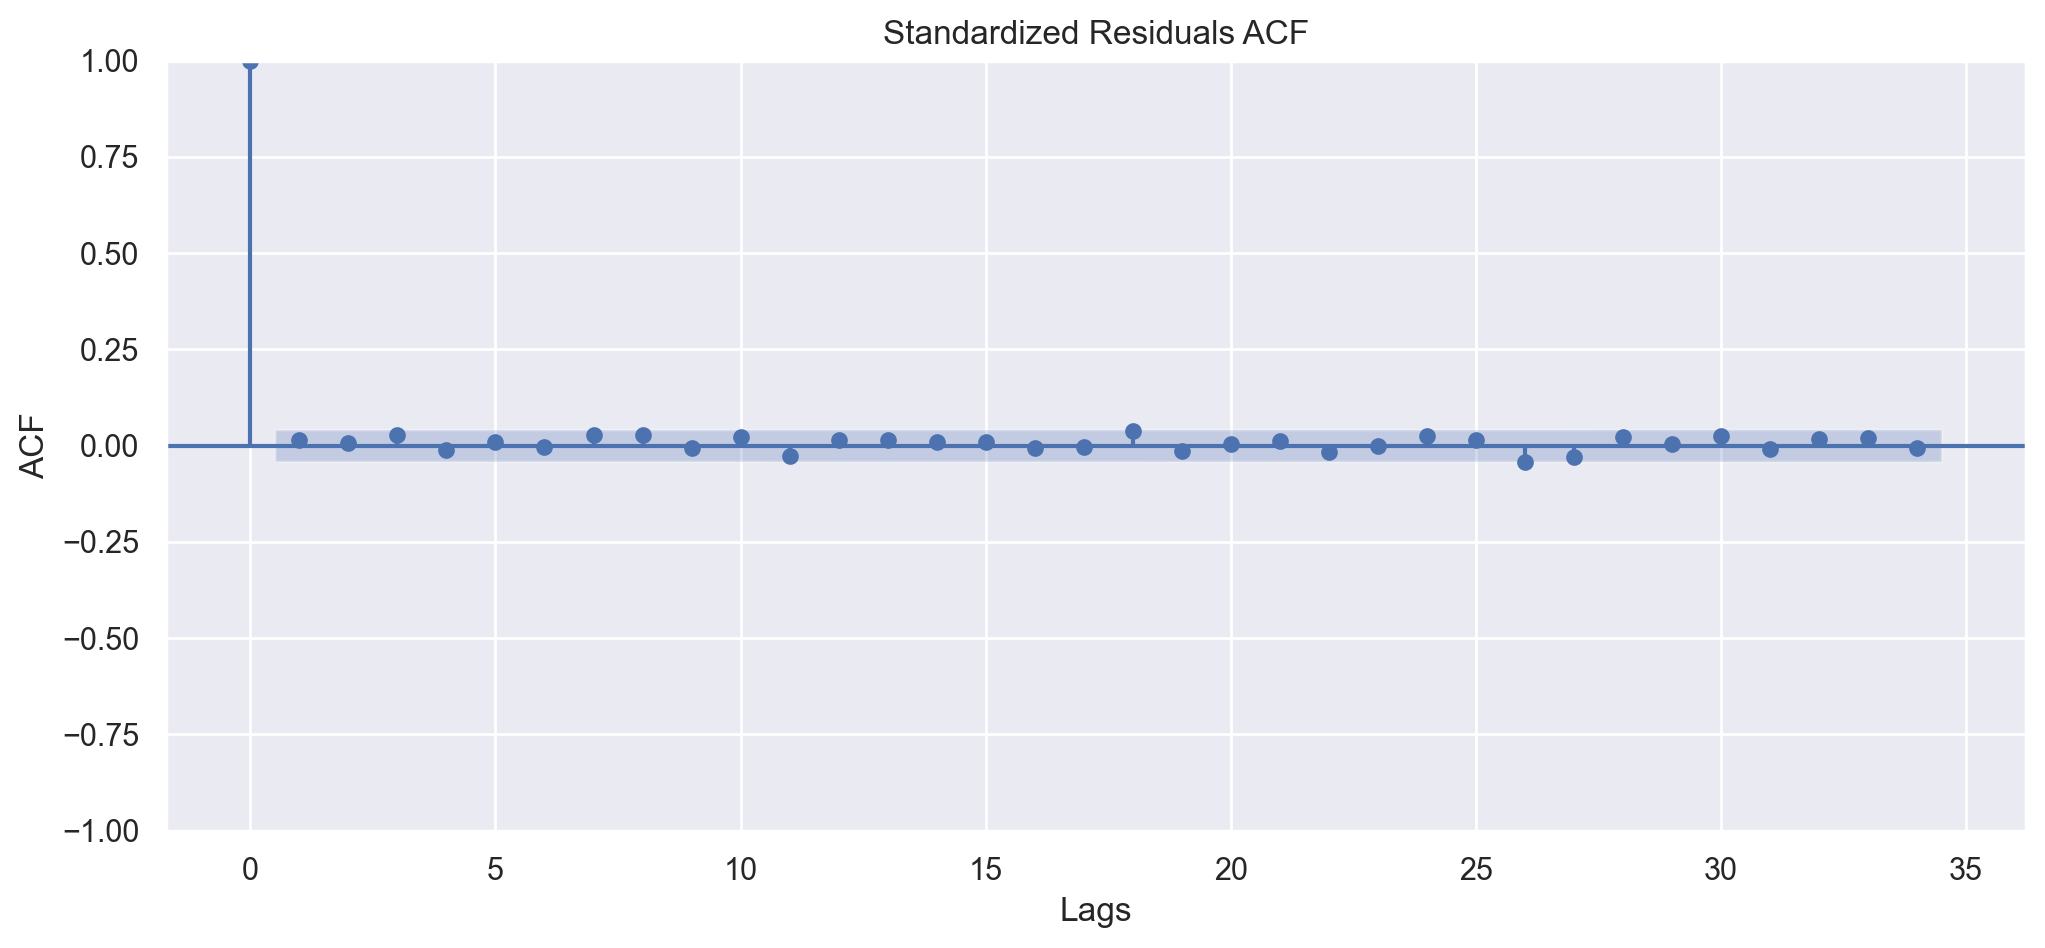

In [268]:
fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(standardized_resid, ax=ax)
ax.set_title("Standardized Residuals ACF")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

plt.show()

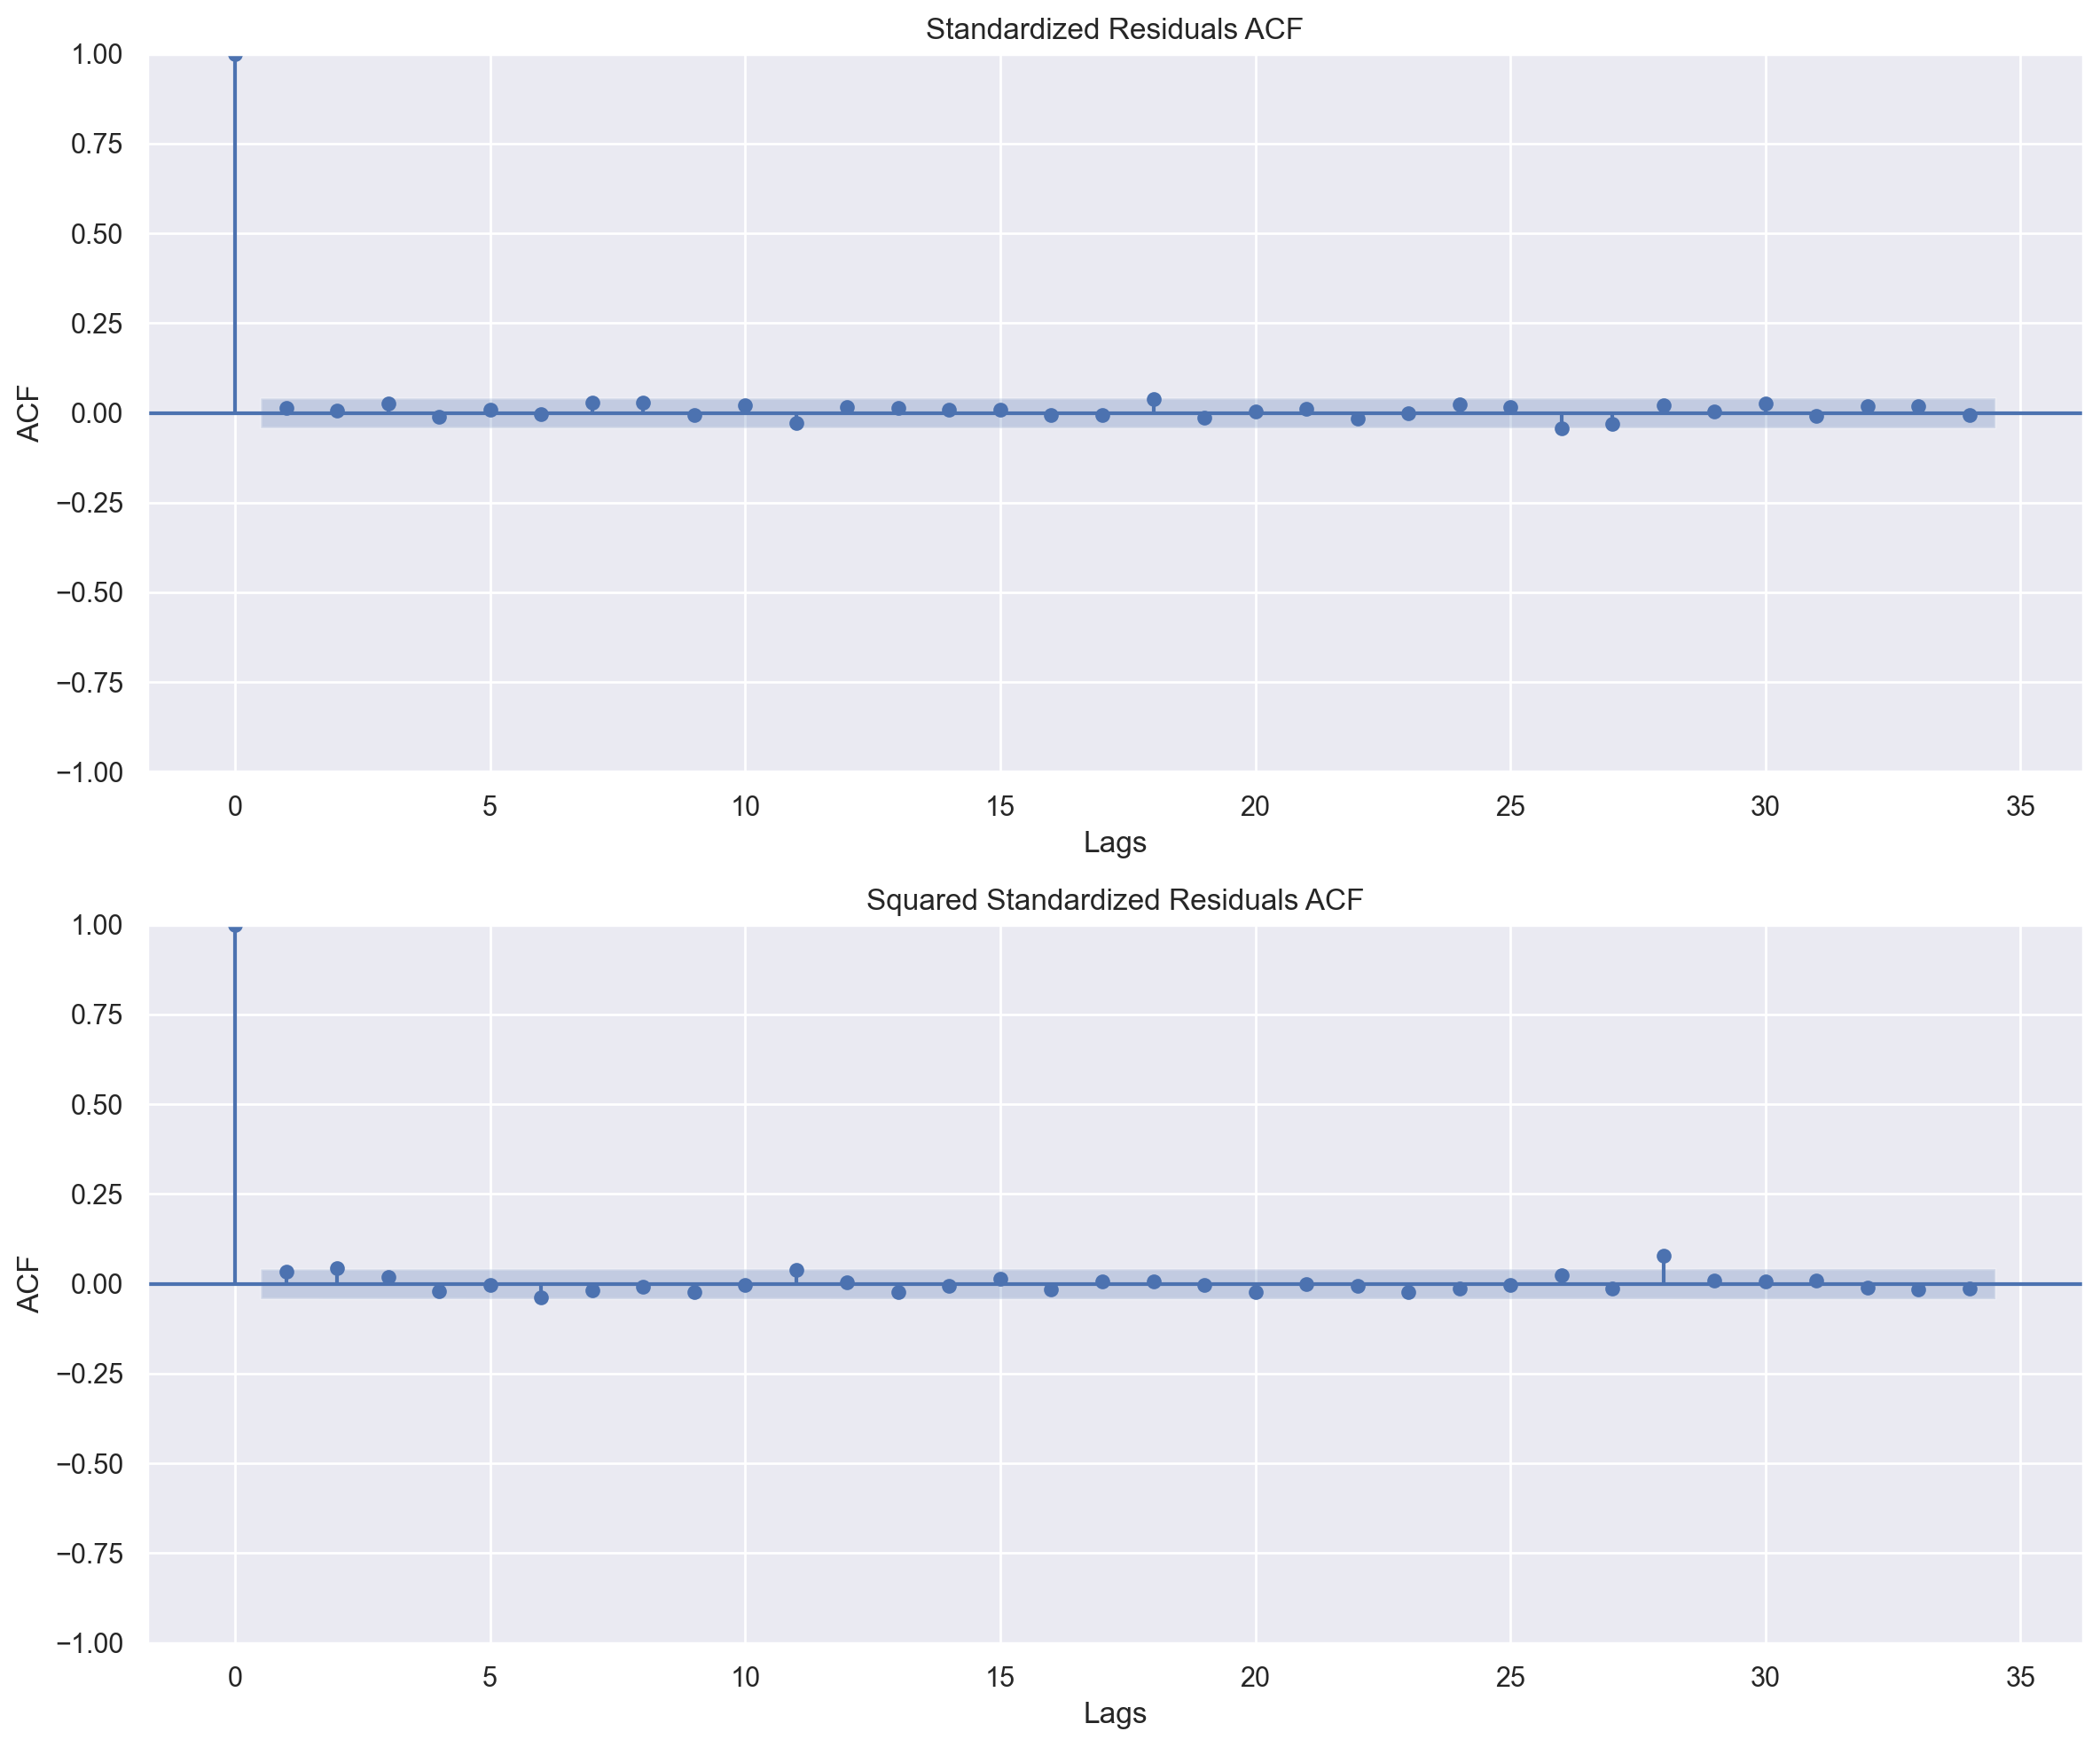

In [269]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sm.graphics.tsa.plot_acf(standardized_resid, ax=ax[0])
sm.graphics.tsa.plot_acf(standardized_resid**2, ax=ax[1])
ax[0].set_title("Standardized Residuals ACF")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("ACF")
ax[1].set_title("Squared Standardized Residuals ACF")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("ACF")
plt.tight_layout()

plt.show()

residuals and squared residuals: non serially correlated -> consistent with independance assumption.

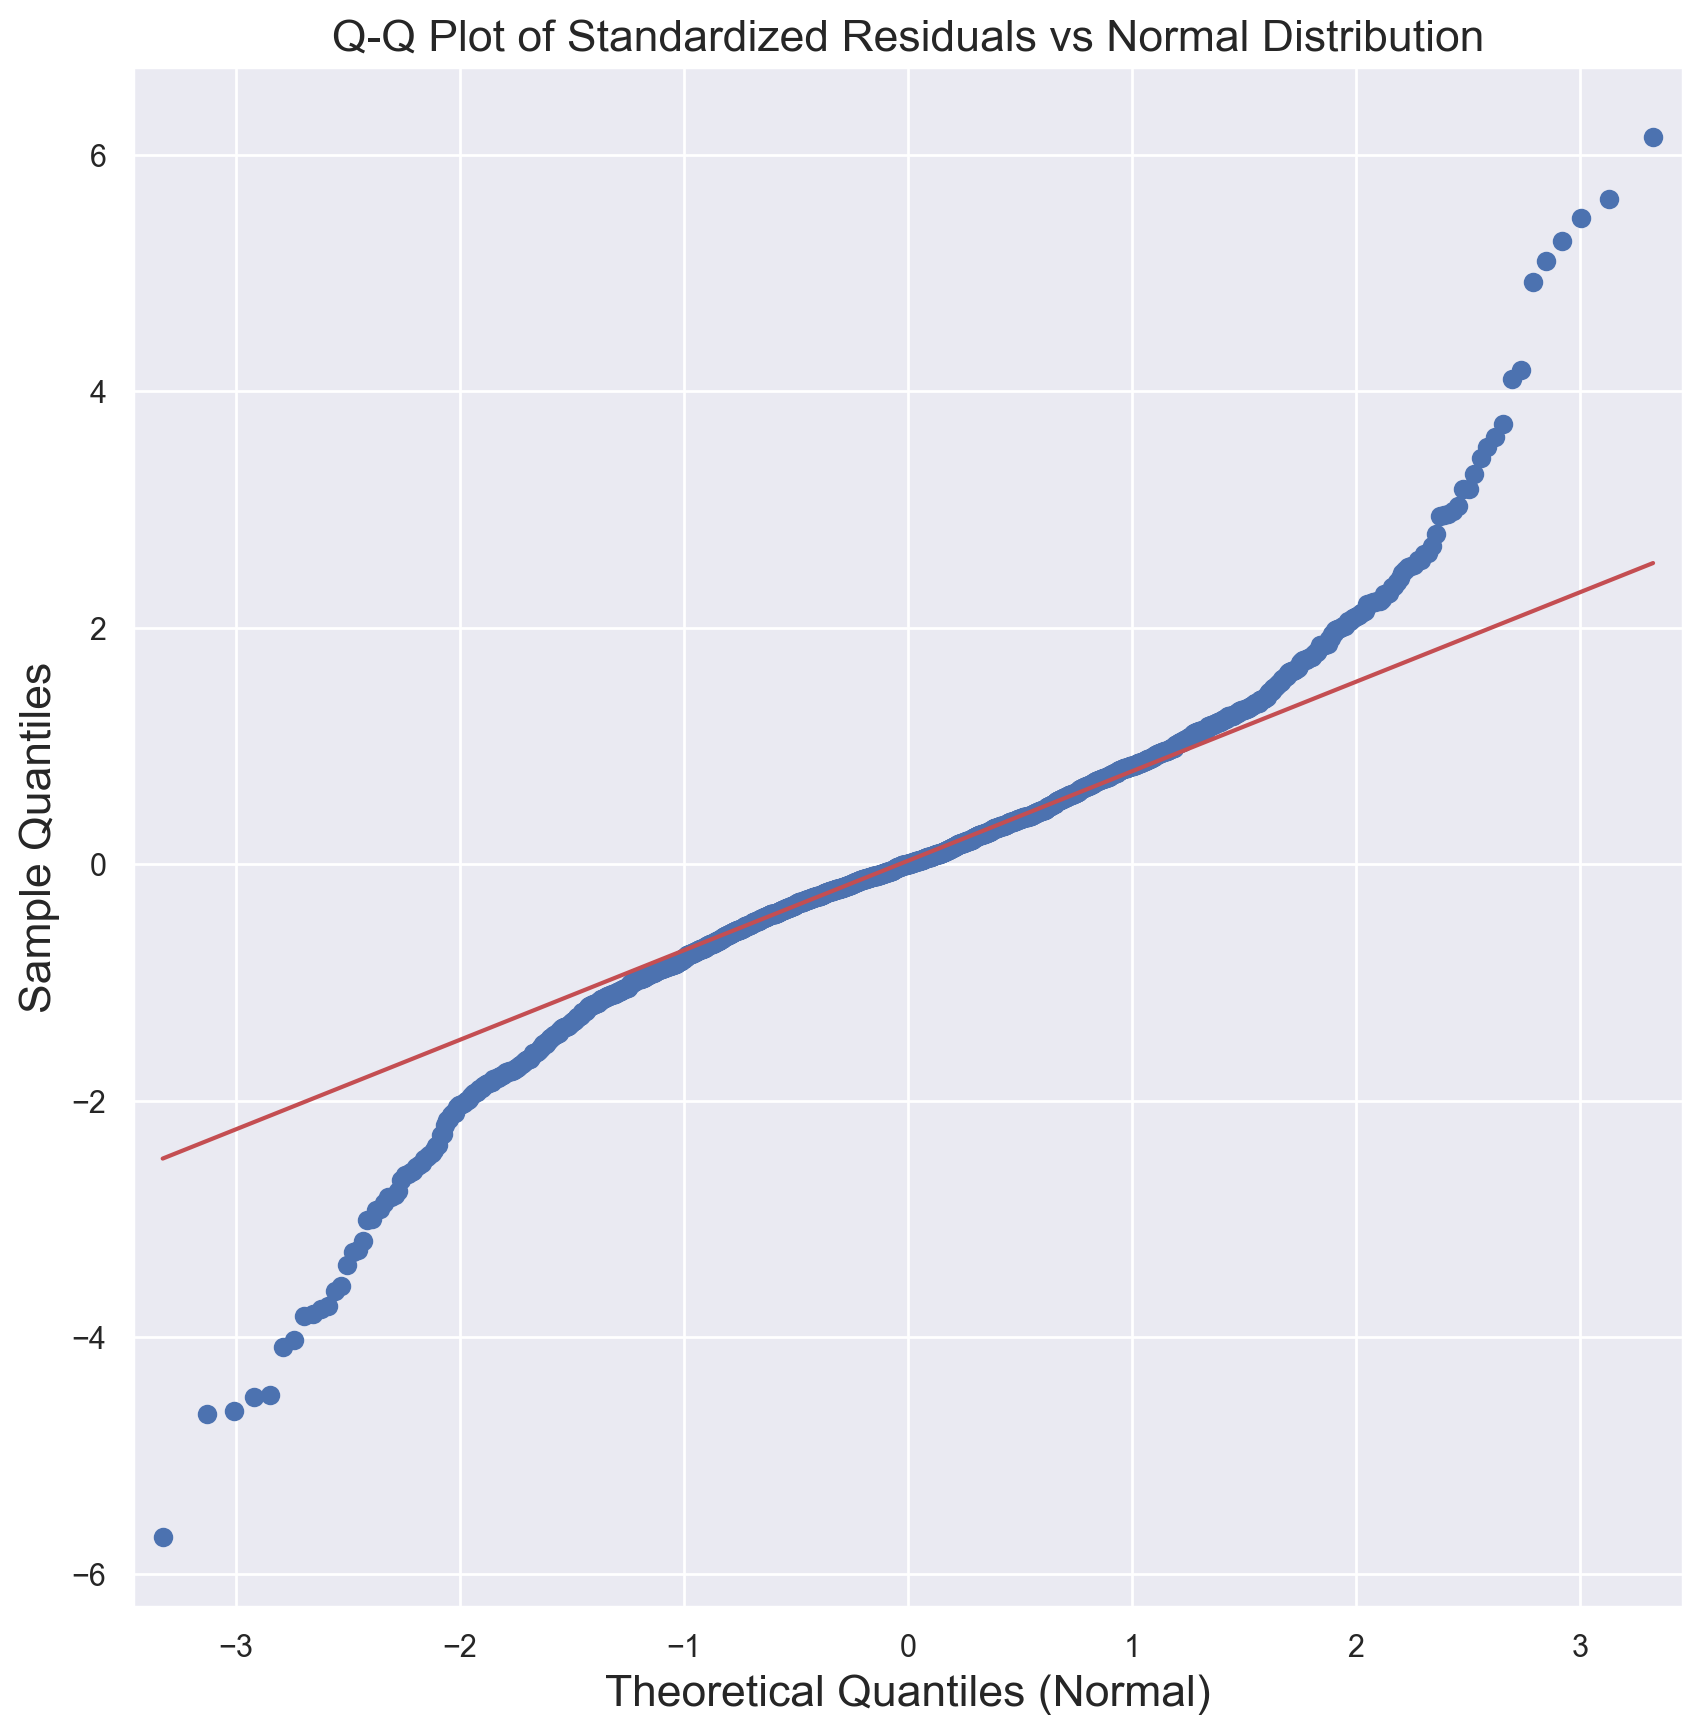

In [270]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(standardized_resid, dist=stats.norm, ax=ax, line='q')
plt.xlabel('Theoretical Quantiles (Normal)', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
plt.title('Q-Q Plot of Standardized Residuals vs Normal Distribution', fontsize=16)
plt.show()

Tails seem heavier on the observed residuals distribution than on the theoretical normal distribution. 

In [271]:
df_estimate, loc_estim, scale_estim = stats.t.fit(standardized_resid)

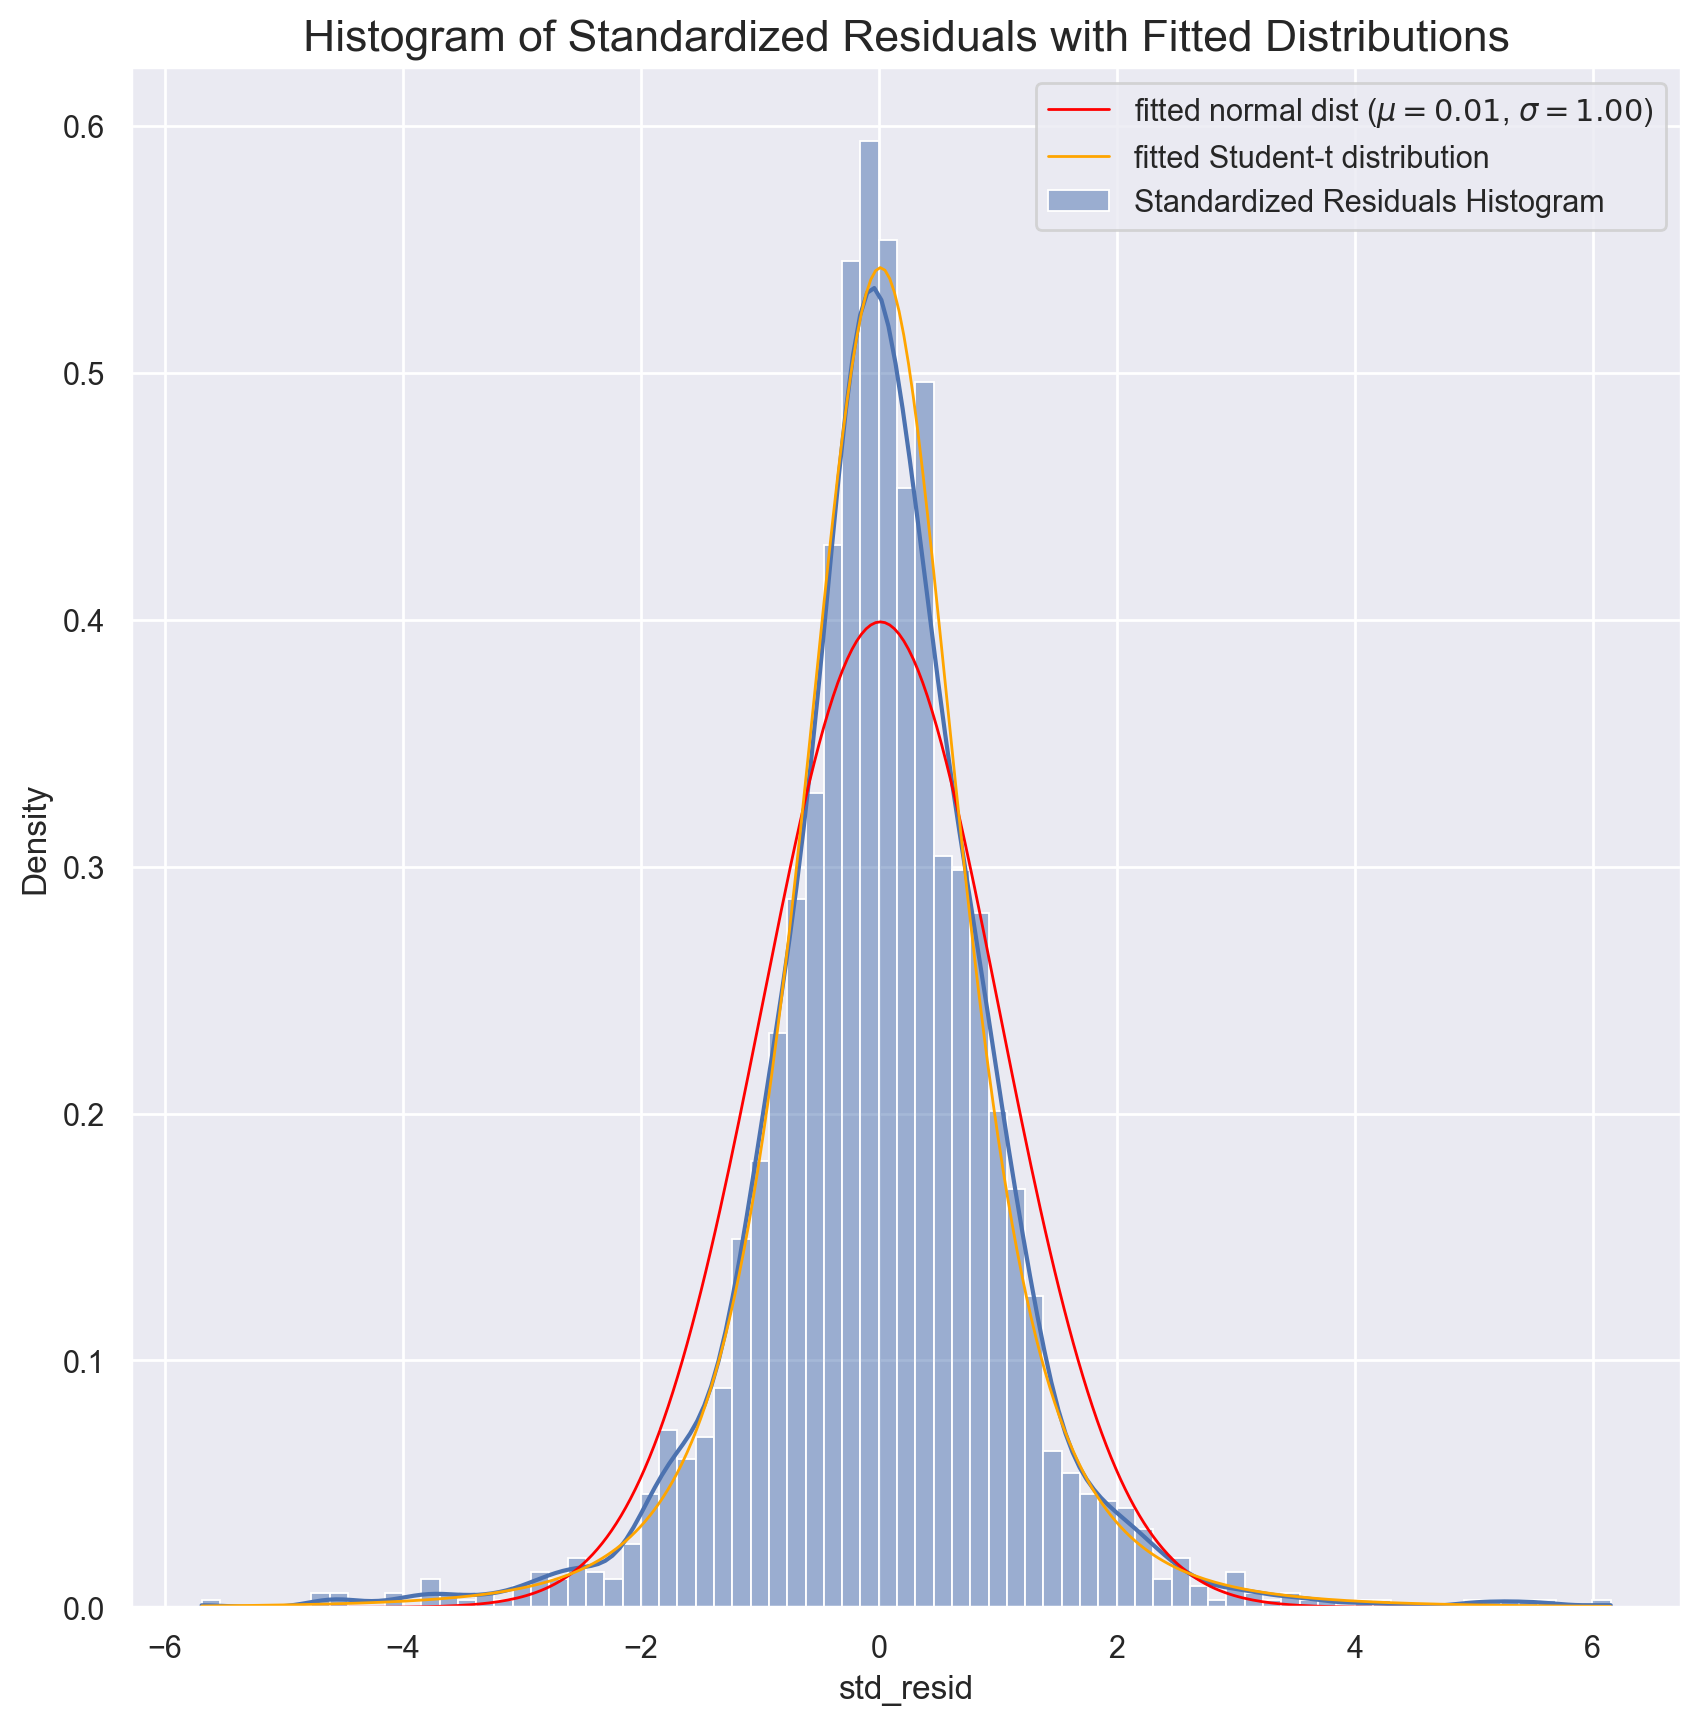

In [272]:
from scipy.stats import norm, t
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(standardized_resid, kde=True, ax=ax, stat='density', label='Standardized Residuals Histogram')
mean, std = np.mean(standardized_resid), np.std(standardized_resid)
xs = np.linspace(min(standardized_resid), max(standardized_resid), 300)
ax.plot(xs, norm.pdf(xs, mean, std), label=f"fitted normal dist ($\mu={mean:.2f}$, $\sigma={std:.2f}$)", linewidth=1, color='red')
ax.plot(xs, t.pdf(xs, df_estimate, loc_estim, scale_estim), label=f"fitted Student-t distribution", linewidth=1, color='orange')
ax.set_title("Histogram of Standardized Residuals with Fitted Distributions", fontsize=16)
ax.legend()

plt.show()

The student-t distribution seems to be a better fit. 

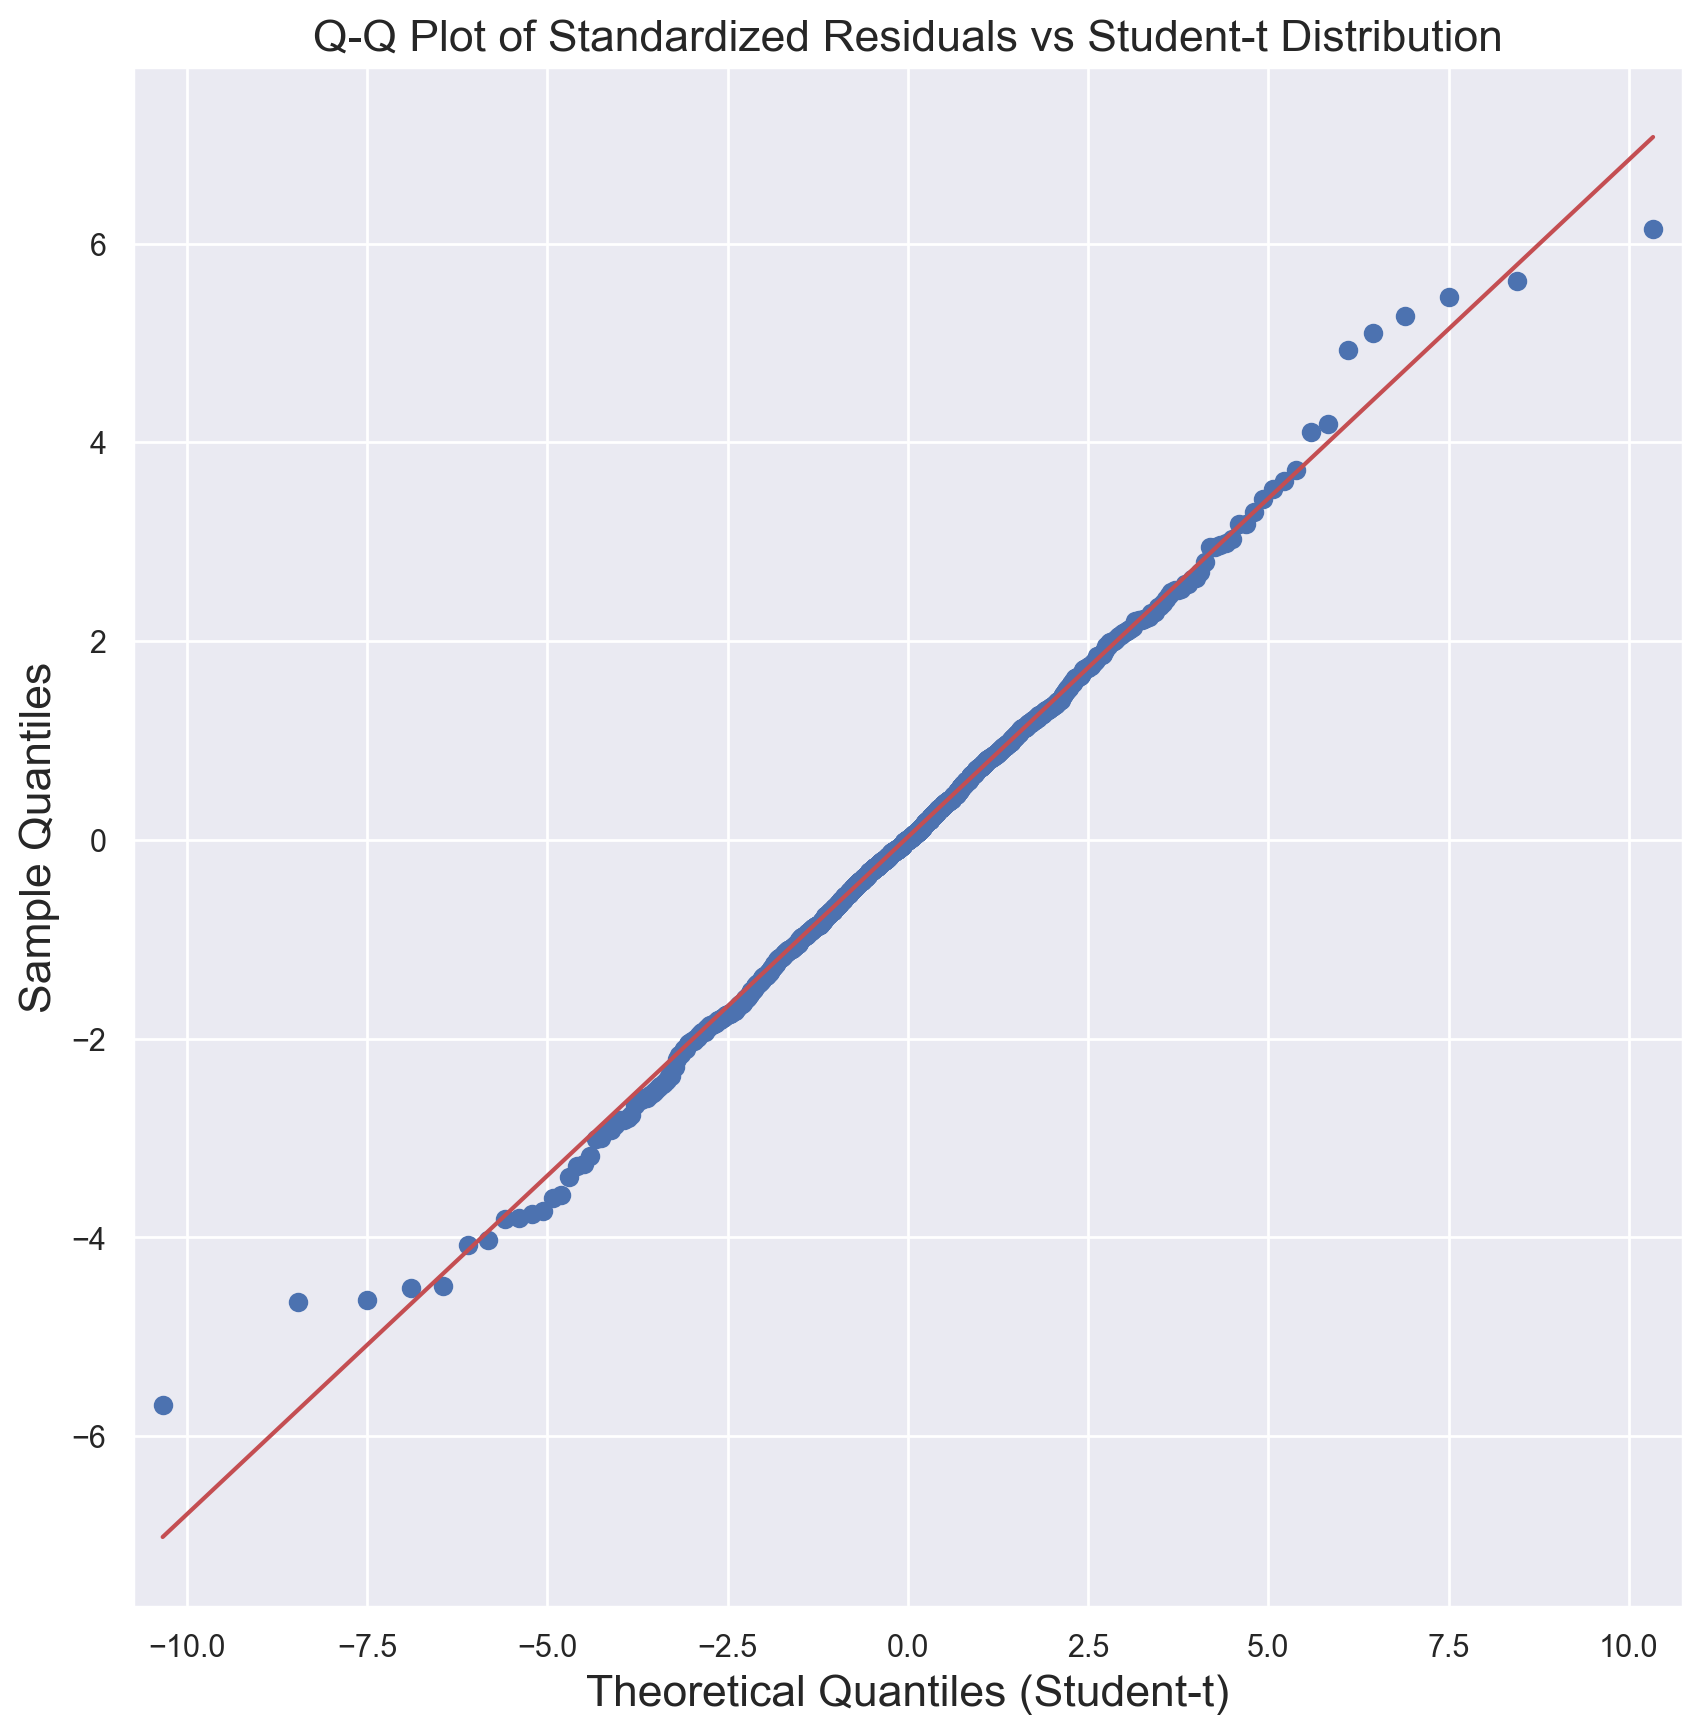

In [273]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(standardized_resid, dist=stats.t, distargs=(df_estimate,), ax=ax, line='q')
plt.xlabel('Theoretical Quantiles (Student-t)', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
plt.title('Q-Q Plot of Standardized Residuals vs Student-t Distribution', fontsize=16)
plt.show()

The standard residuals seem to be drawn from a Student-t distribution. Thus, the assumption of the residuals being identically-distributed seems fair. 

In [274]:
train_df.loss.sum()

np.float64(515.2806204254168)

In [303]:
thresholds = res.std_resid.sort_values().to_list()
x = []
excess_means = []
for thresh in thresholds:
    excess_df = res.std_resid[res.std_resid>thresh]-thresh
    nb_excess = excess_df.count()
    excess_mean = excess_df.sum()/nb_excess if nb_excess>0 else None
    if len(excess_means)>0 and excess_mean!=excess_means[-1]:
        excess_means.append(excess_mean)
        x.append(thresh)
    elif len(excess_means)==0:
        excess_means.append(excess_mean)
        x.append(thresh)

C:\Users\ilias\AppData\Local\Temp\ipykernel_9176\1504346074.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


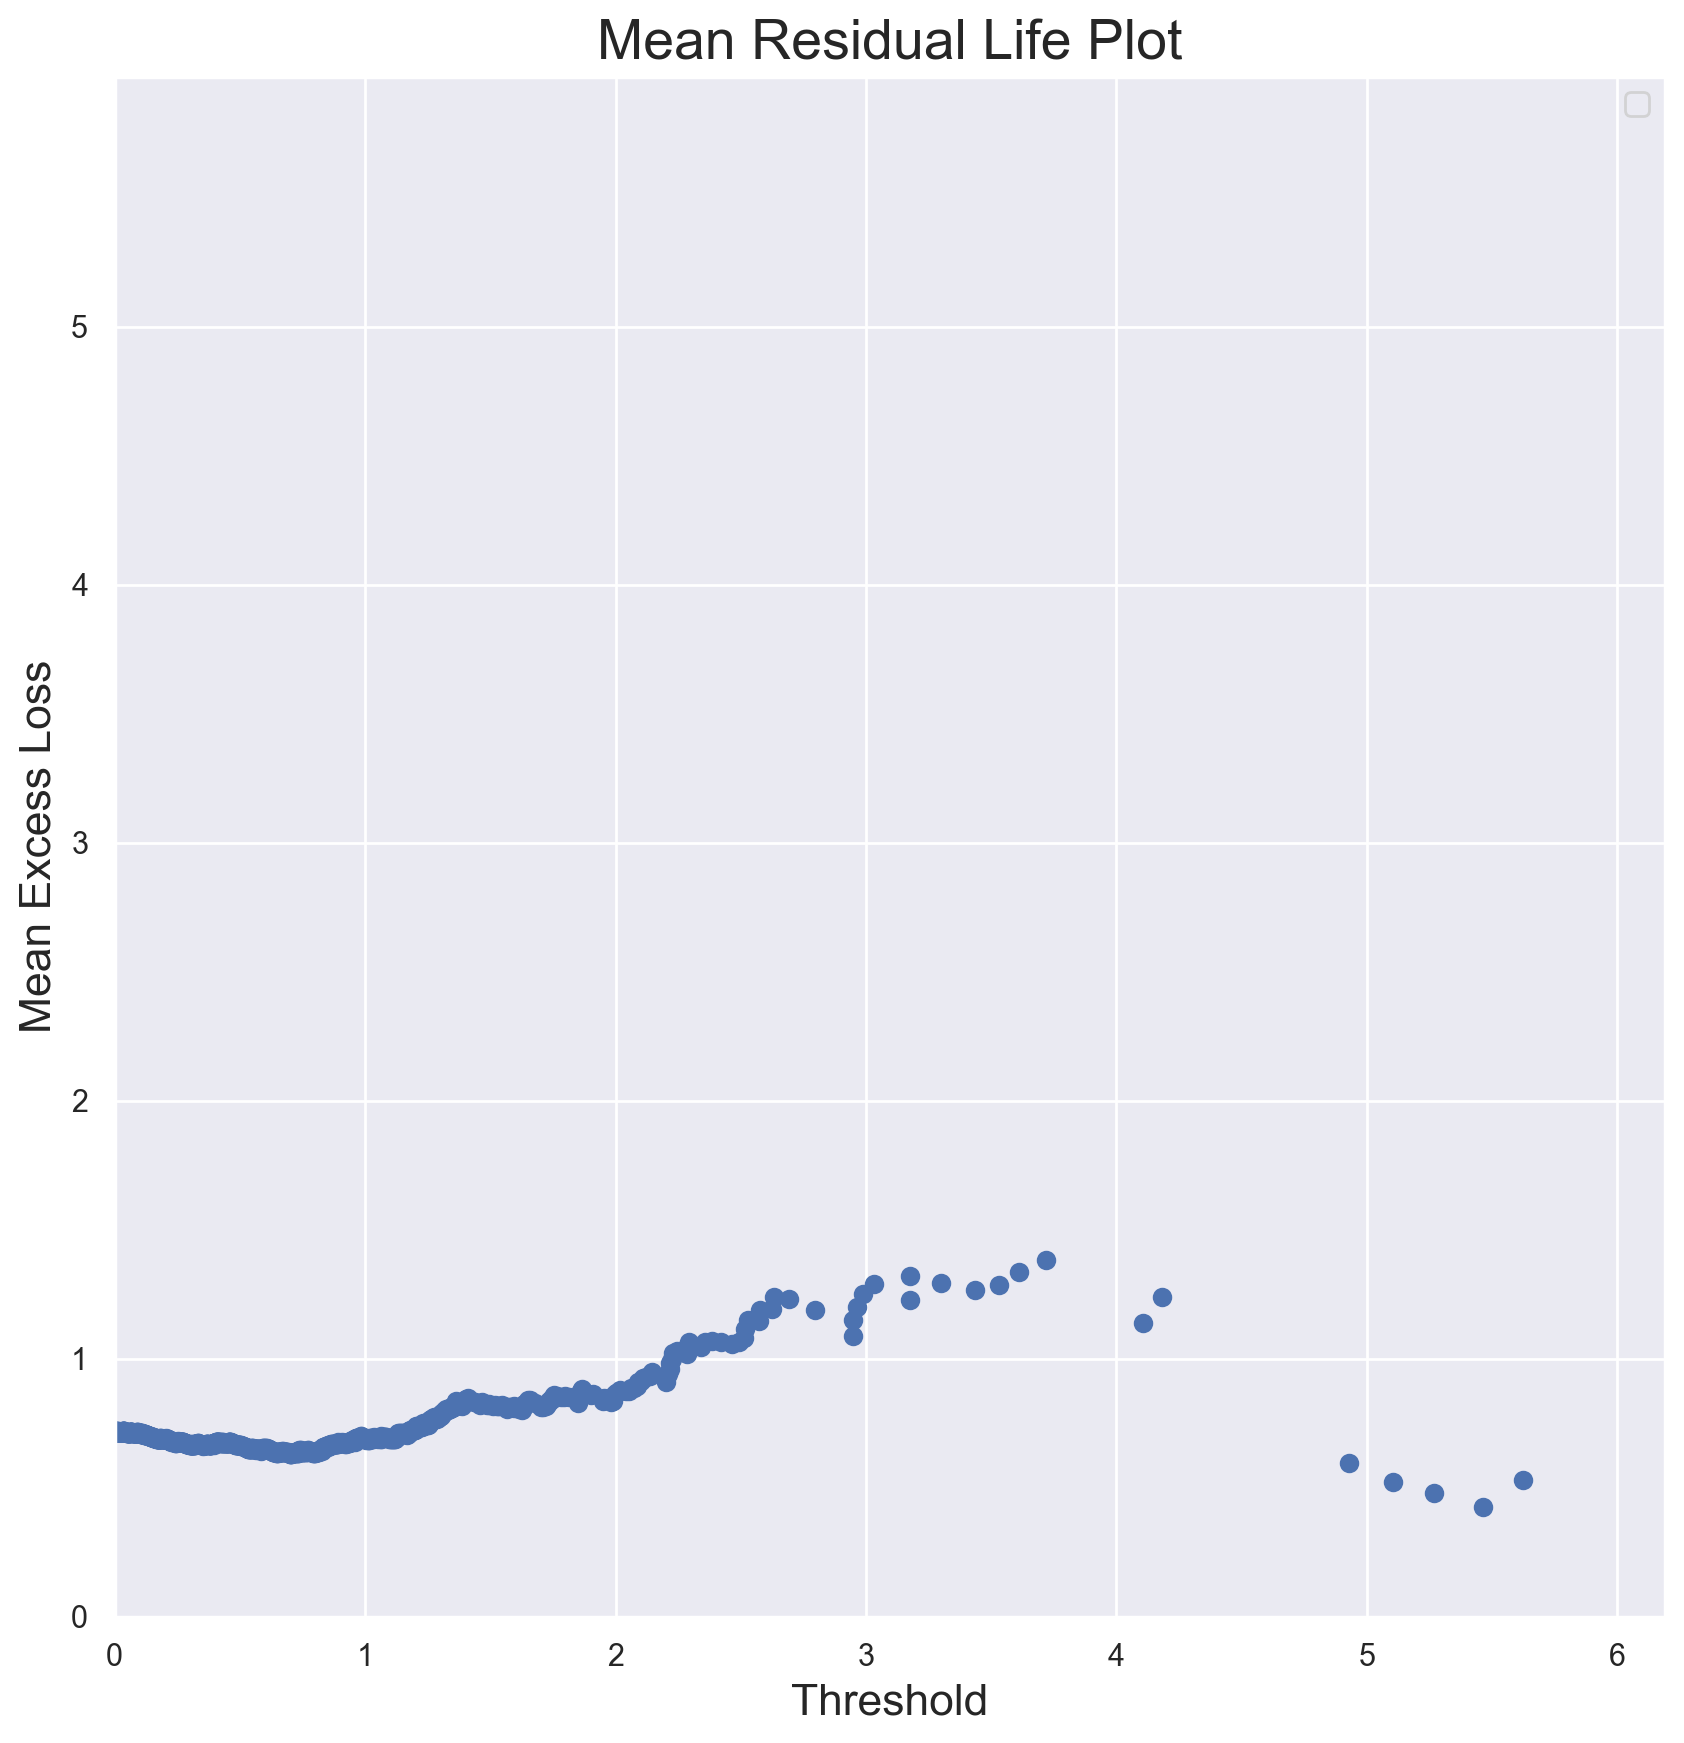

In [304]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, excess_means)

#abs = np.linspace(-10, 10, 100)
#y = slope * abs + intercept
#plt.plot(abs, y, color='red')
#plt.scatter(0.12, 2.54, color='red', s=100, zorder=5)
plt.legend()
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Mean Excess Loss', fontsize=16)
plt.title('Mean Residual Life Plot', fontsize=20)
plt.ylim(0)
plt.xlim(0)
plt.show()

There seems to be two linear tendencies on the mean excess plot. We want to have a linear trend after a certain threshold u. This threshold is set at u=0.5, as we can see on the graph above. 

In [305]:
u = 1
excess_df = res.std_resid[res.std_resid>u]-u


In [306]:
from scipy.stats import genpareto
params = genpareto.fit(excess_df)

In [307]:
GPD_shape, GPD_loc, GPD_scale  = params

In [308]:
params

(np.float64(0.19235233124315387),
 np.float64(0.003396542171041738),
 np.float64(0.5533943509053127))

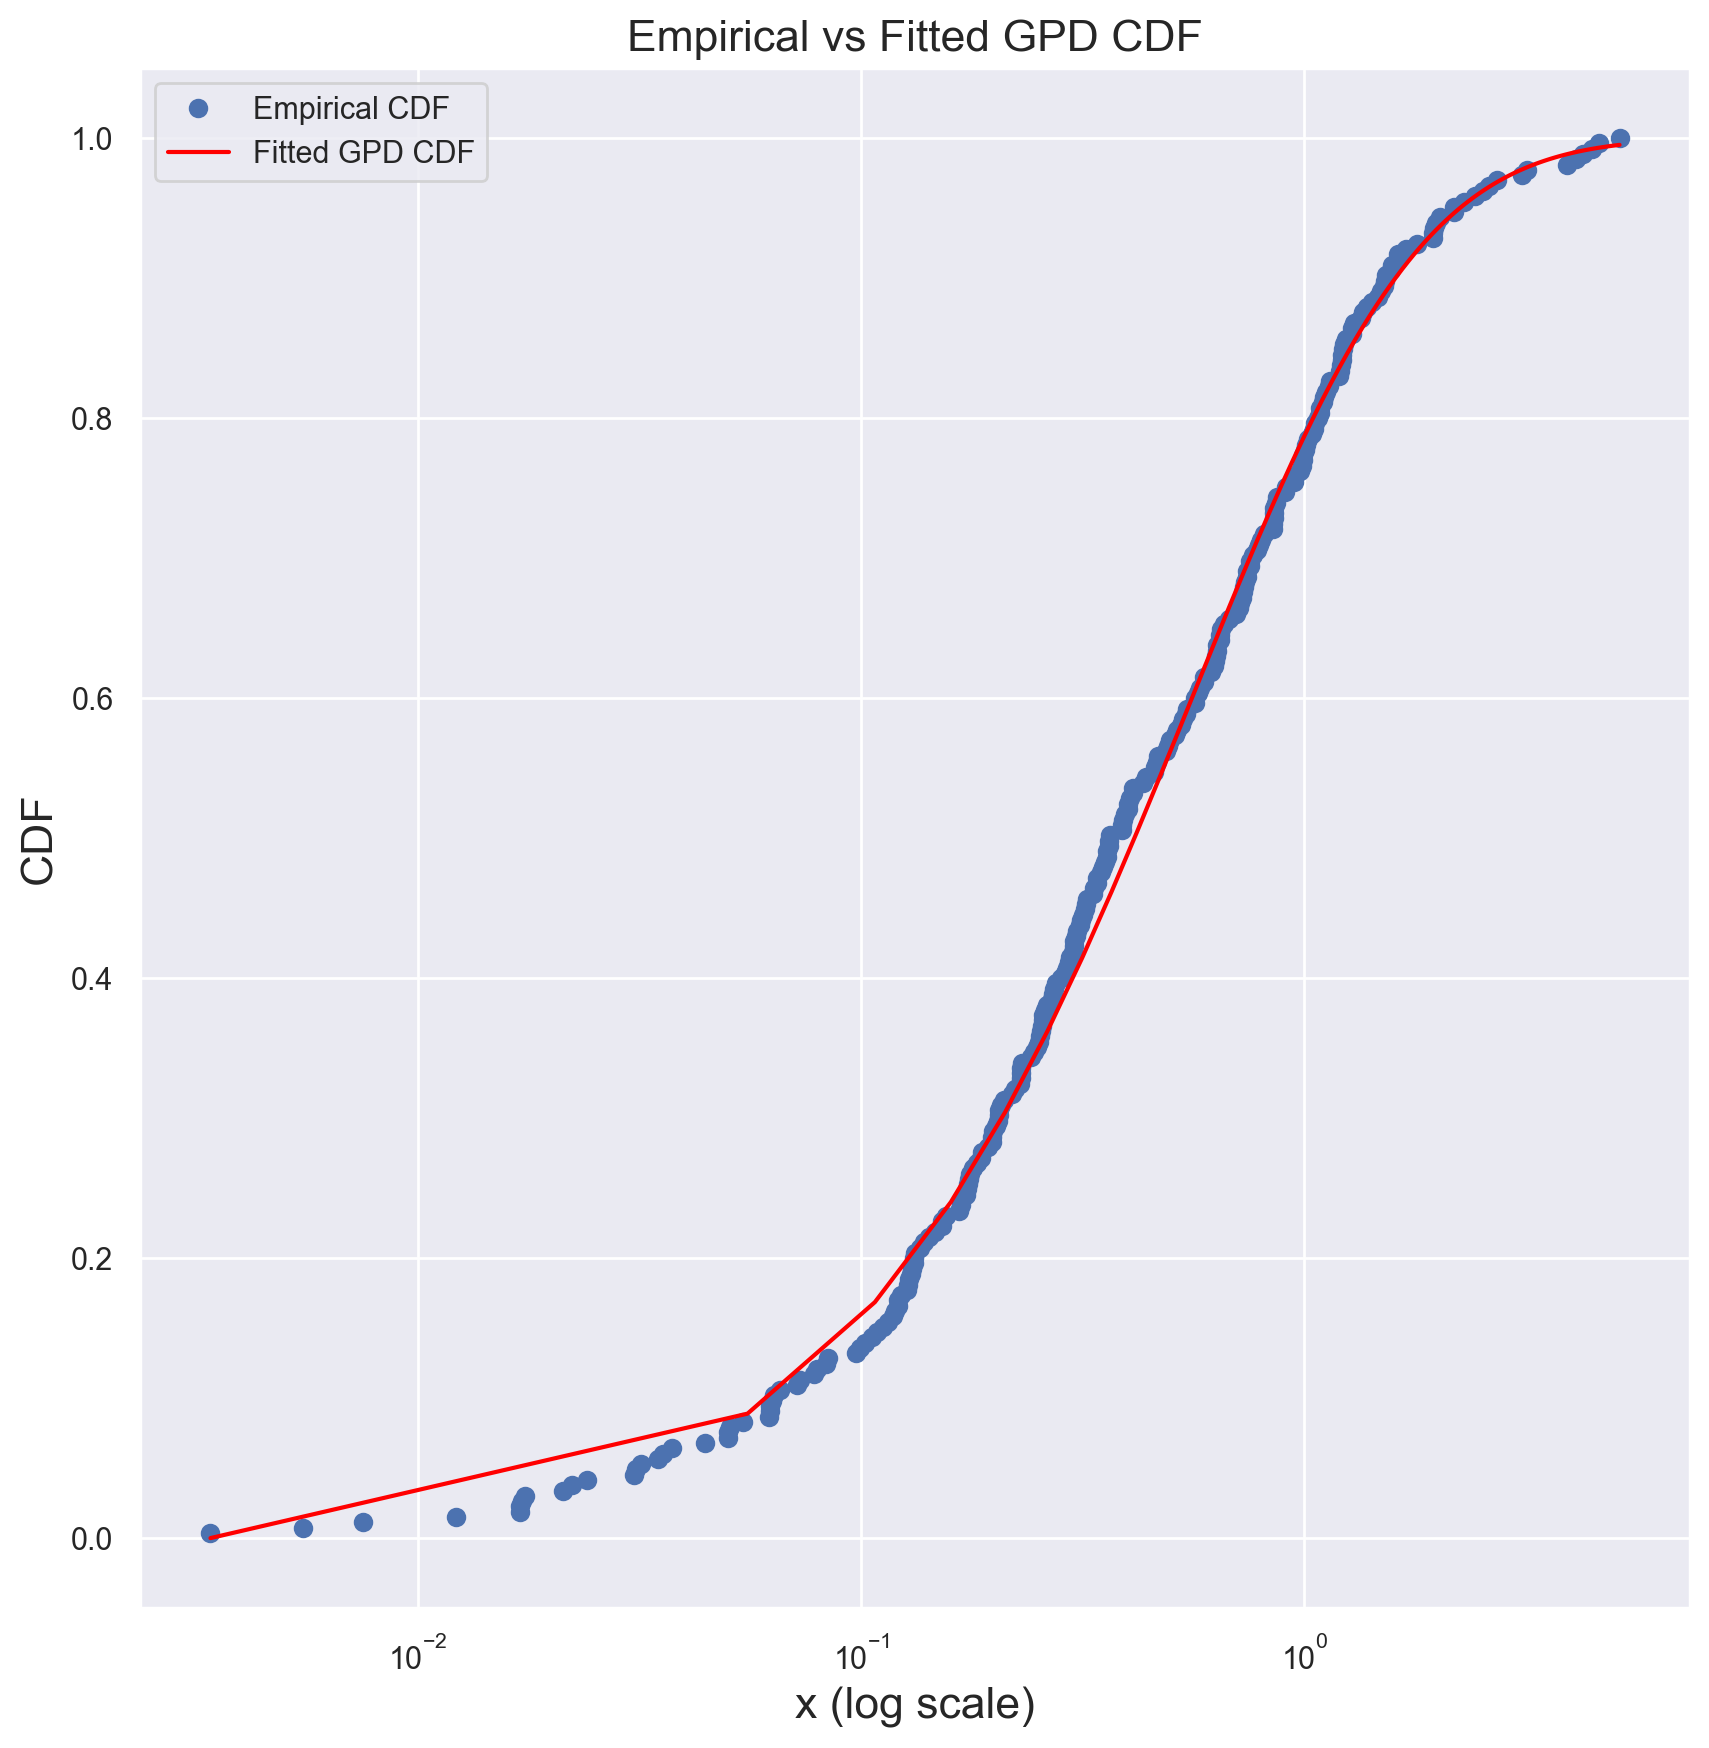

In [309]:
sorted = excess_df.sort_values().reset_index(drop=True)
cdf_values = []
for i in range(len(excess_df)):
        cdf_value = np.sum(sorted <= sorted[i]) / len(excess_df)
        cdf_values.append(cdf_value)


plt.figure(figsize=(10, 10))
plt.plot(np.sort(excess_df), cdf_values, marker='o', linestyle='', label='Empirical CDF')
x = np.linspace(min(excess_df), max(excess_df), 100)
plt.plot(x, genpareto.cdf(x, params[0], params[1], params[2]), label='Fitted GPD CDF', color='red')
plt.legend()
plt.gca().set_xscale('log', base=10)
plt.title("Empirical vs Fitted GPD CDF", fontsize=16)
plt.xlabel("x (log scale)", fontsize=16)
plt.ylabel("CDF", fontsize=16)
plt.show()

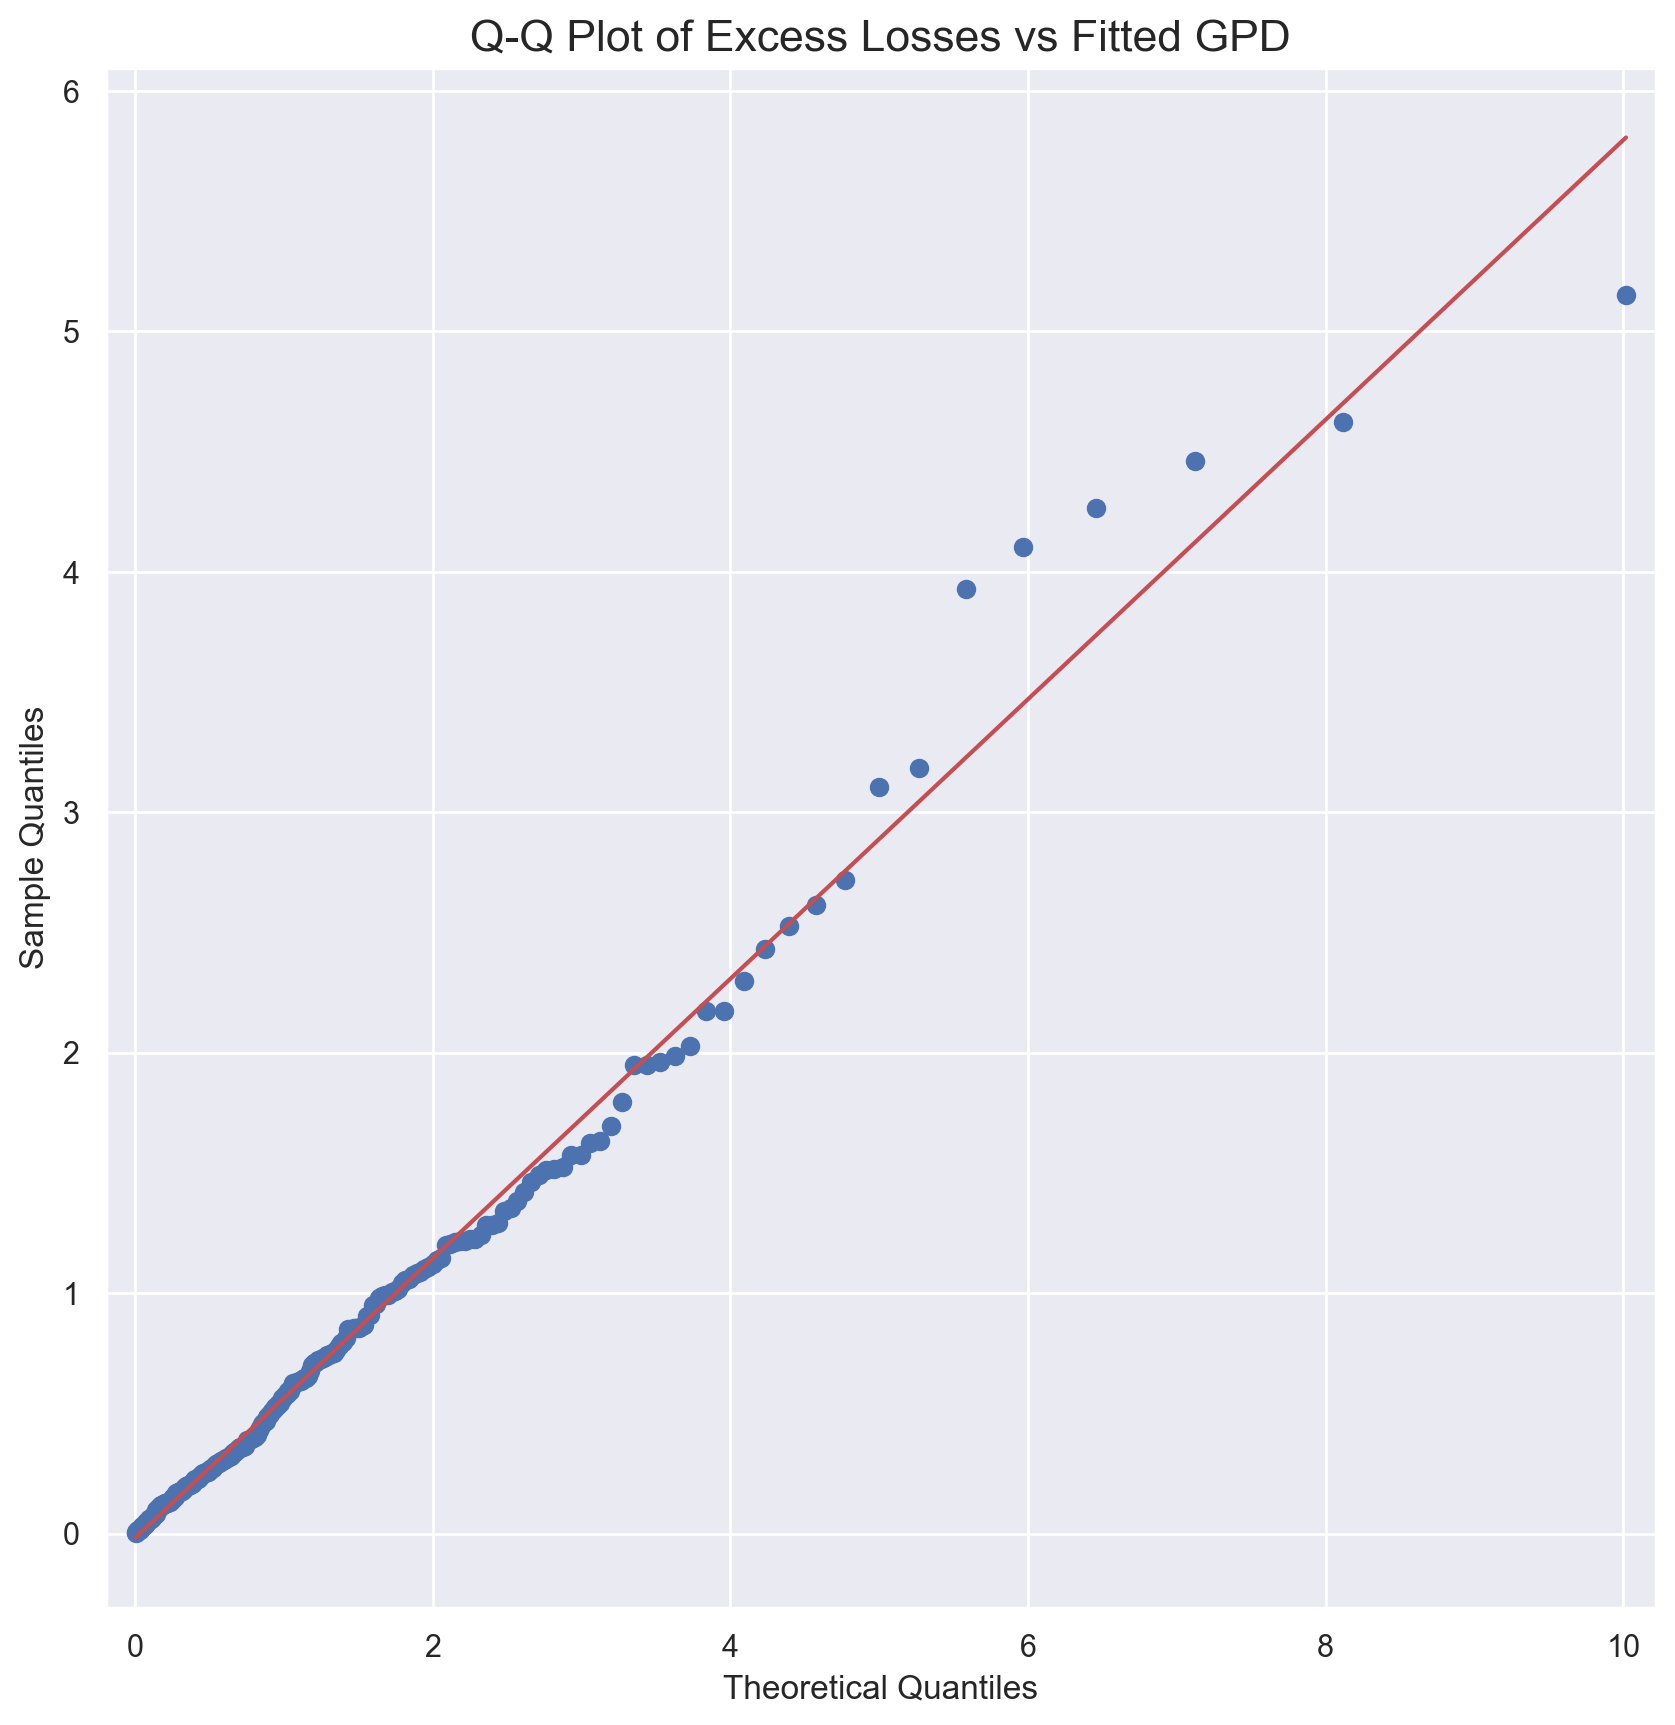

In [310]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(excess_df, dist=genpareto, distargs=(params[0],), ax=ax, line='r')
plt.title('Q-Q Plot of Excess Losses vs Fitted GPD', fontsize=16)
plt.show()

In [311]:
from scipy.stats import kstest
ks_statistic, p_value = kstest(excess_df, 'genpareto', args=params)
alpha = 0.05
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}, so we reject the null hypothesis.")
    print("The data does not appear to follow a Generalized Pareto Distribution with the estimated parameters.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than {alpha}, so we fail to reject the null hypothesis.")
    print("The data appears to follow a Generalized Pareto Distribution with the estimated parameters.")

The p-value (0.7136) is greater than 0.05, so we fail to reject the null hypothesis.
The data appears to follow a Generalized Pareto Distribution with the estimated parameters.


## VaR with GARCH(1,1) and normal innovations

Fitting the model on train data

In [312]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109977.43472223838
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948143837401
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970834915617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.87203617076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501525208385
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248120761451
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7993379015425
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.344203611621
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254442988
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119616166
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900442
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

In [313]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Tue, Dec 02 2025   Df Residuals:                     2265
Time:                        17:30:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1506  6.416e-02      2.347  1.891e-02 [2.485e-0

In [314]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [315]:
stats.norm.ppf(0.95)
stats.norm.ppf(0.99)

np.float64(2.3263478740408408)

In [316]:
mus.index = test_df.Date
sigmas.index = test_df.Date

In [317]:
test_df['mus'], test_df['sigmas'] = mus.values, sigmas.values
test_df['VaR95'] = test_df['mus'] + test_df['sigmas']*stats.norm.ppf(0.95)
test_df

,Date,TSLA,log_returns,loss,VaR_99,mus,sigmas,VaR95
2267,2021-11-26,360.640015,3.101358,-3.101358,5.842857,0.150609,3.766584,6.346088
2268,2021-11-29,378.996674,-4.964716,4.964716,5.808577,0.150609,3.764631,6.342877
2269,2021-11-30,381.586670,-0.681058,0.681058,5.884204,0.150609,3.762699,6.339699
2270,2021-12-01,365.000000,4.444065,-4.444065,5.761986,0.150609,3.760787,6.336554
2271,2021-12-02,361.533325,0.954313,-0.954313,5.820600,0.150609,3.758895,6.333441
...,...,...,...,...,...,...,...,...
2514,2022-11-18,180.190002,1.640281,-1.640281,5.942922,0.150609,3.594740,6.063431
2515,2022-11-21,167.869995,7.082202,-7.082202,5.844352,0.150609,3.594602,6.063203
2516,2022-11-22,169.910004,-1.207907,1.207907,6.142353,0.150609,3.594464,6.062977
2517,2022-11-23,183.199997,-7.530953,7.530953,6.021938,0.150609,3.594329,6.062754


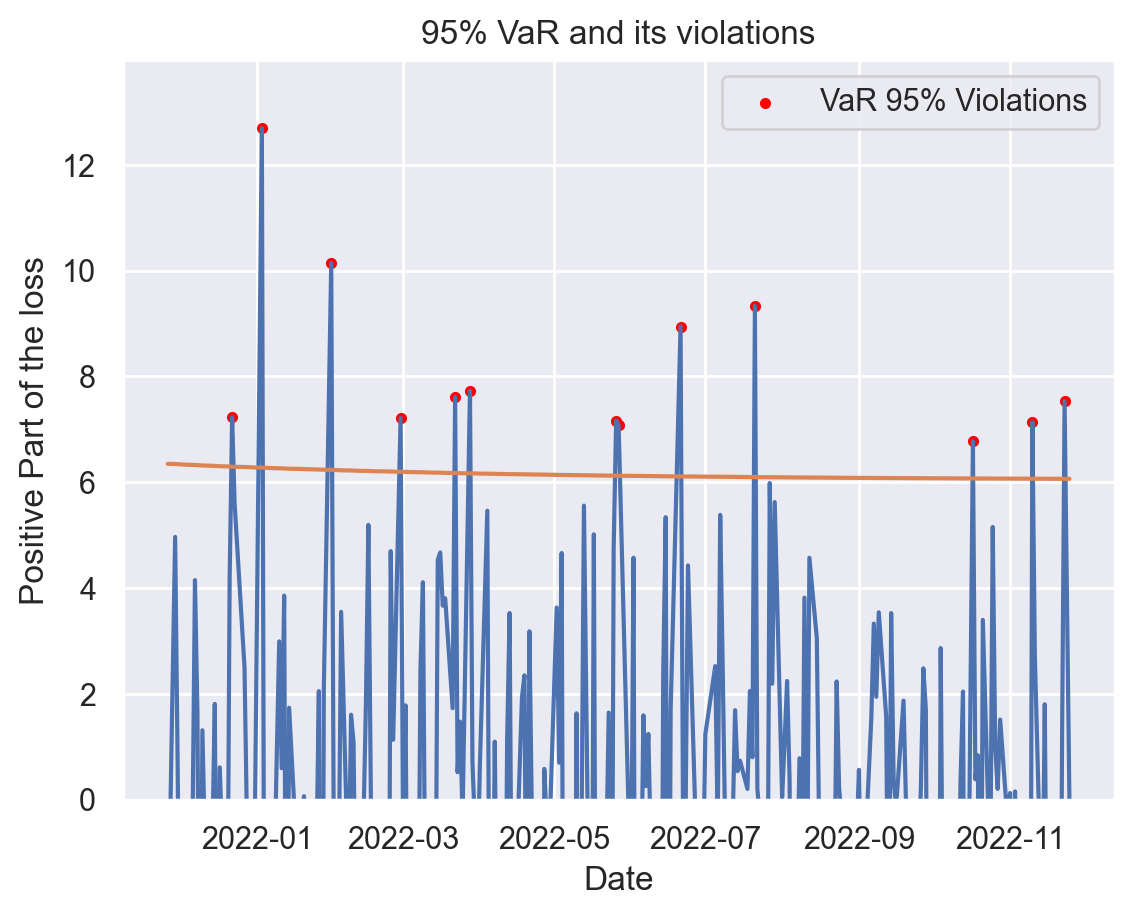

In [318]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95'])
plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations')
plt.show()


## GARCH(1,1) with standardized t-student innovations

In [319]:
Garch_t = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='t')
res = Garch_t.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 53371.352146943726
Iteration:      2,   Func. Count:     15,   Neg. LLF: 58997.98097858561
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9431.712458270858
Iteration:      4,   Func. Count:     33,   Neg. LLF: 7222.195873026622
Iteration:      5,   Func. Count:     40,   Neg. LLF: 6376.343660116498
Iteration:      6,   Func. Count:     47,   Neg. LLF: 7406.9078803776565
Iteration:      7,   Func. Count:     54,   Neg. LLF: 5681.16565525633
Iteration:      8,   Func. Count:     61,   Neg. LLF: 5678.13517294055
Iteration:      9,   Func. Count:     68,   Neg. LLF: 7216.493821495537
Iteration:     10,   Func. Count:     75,   Neg. LLF: 5673.941018777678
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5673.900408927042
Iteration:     12,   Func. Count:     87,   Neg. LLF: 5673.898056311651
Iteration:     13,   Func. Count:     93,   Neg. LLF: 5673.897929073833
Iteration:     14,   Func. Count:     99,   Neg. LLF: 5673.89790

In [320]:
res

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         loss   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5673.90
Distribution:      Standardized Student's t   AIC:                           11357.8
Method:                  Maximum Likelihood   BIC:                           11386.4
                                              No. Observations:                 2266
Date:                      Tue, Dec 02 2025   Df Residuals:                     2265
Time:                              17:30:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [321]:
df = res.params['nu']

In [322]:
df

np.float64(3.56232802105223)

In [323]:
preds = res.forecast(horizon=len(test_df))
must = preds.mean.squeeze()
sigmast = np.sqrt(preds._residual_variance.squeeze())

In [324]:
res.params.mu

np.float64(0.1858972905084269)

In [325]:
loc = np.mean(res.resid)
loc

np.float64(0.04149927631655852)

In [329]:
scale_std = np.sqrt((df - 2.0) / df)
q95 = stats.t.ppf(0.95, df=df, scale=1, loc=0)*scale_std

In [330]:
test_df['must'], test_df['sigmast'] = must.values, sigmast.values
test_df['VaR95t'] = test_df['must'] + test_df['sigmast']*q95

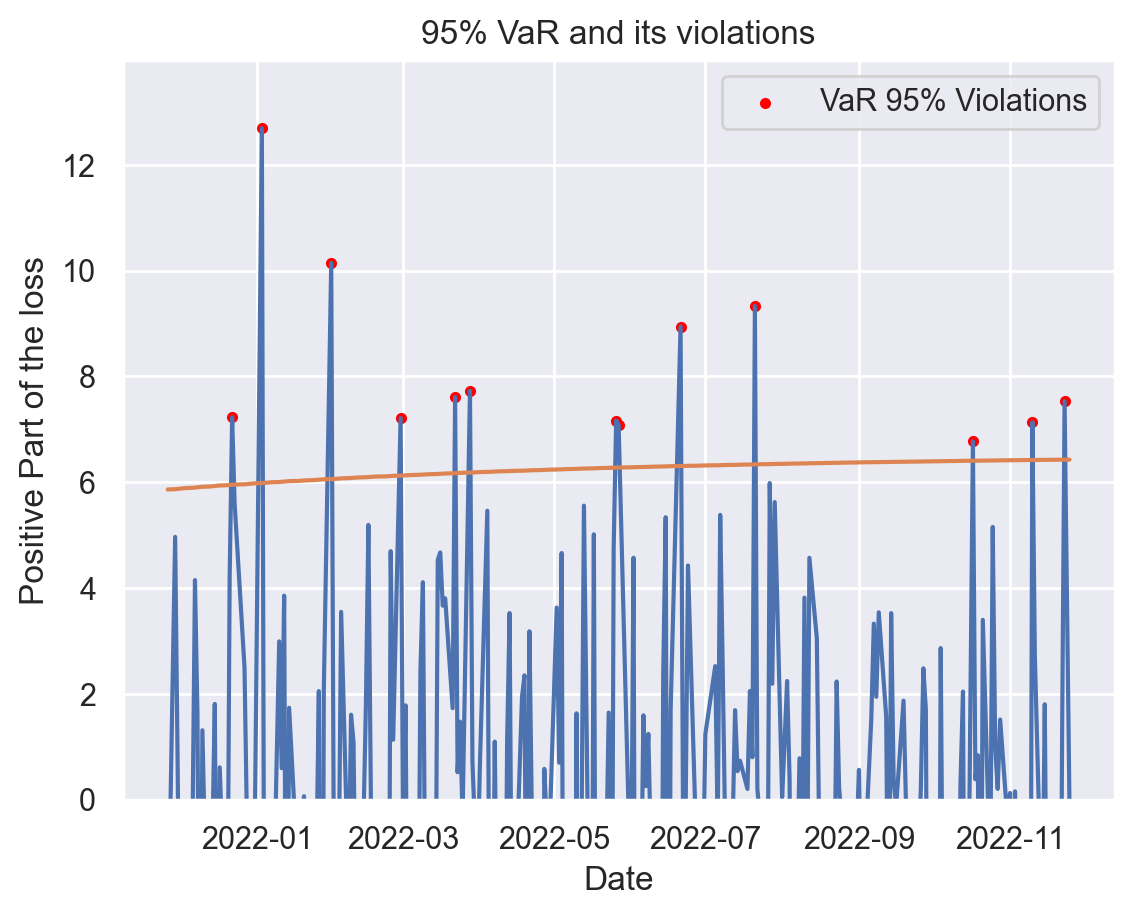

In [331]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95t'])
plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95t']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations')
plt.show()


## GPD model of excess values

In [332]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109977.43472223838
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948143837401
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970834915617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.87203617076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501525208385
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248120761451
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7993379015425
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.344203611621
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254442988
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119616166
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900442
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

In [333]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [334]:
from statsmodels.distributions.empirical_distribution import ECDF

zeta, beta = GPD_shape, GPD_scale
ecdf = ECDF(res.std_resid)
F_u = ecdf(u)
print(F_u)

0.883053839364519


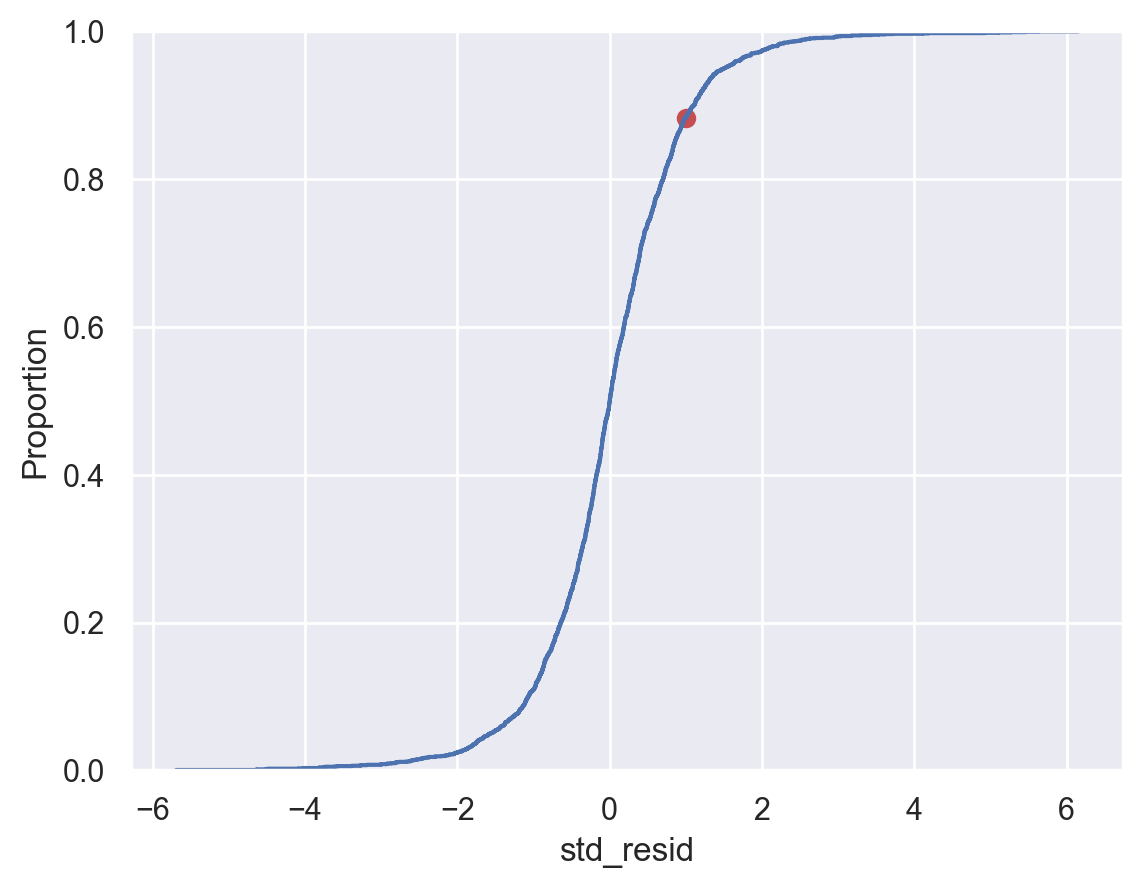

In [335]:
#check if the F_u is the correct value
sns.ecdfplot(res.std_resid)
plt.scatter(u, F_u, color='r')
plt.show()

In [336]:
q95GPD = (u + ((beta/zeta) * ((((1-0.95)/(1-F_u))**(-zeta))  -1 )))
test_df['VaR95GPD'] = test_df['mus'] + test_df['sigmas']*q95GPD

In [337]:
beta

np.float64(0.5533943509053127)

In [338]:
test_df.head()

,Date,TSLA,log_returns,loss,VaR_99,mus,sigmas,VaR95,must,sigmast,VaR95t,VaR95GPD
2267,2021-11-26,360.640015,3.101358,-3.101358,5.842857,0.150609,3.766584,6.346088,0.185897,3.878945,5.861372,5.841246
2268,2021-11-29,378.996674,-4.964716,4.964716,5.808577,0.150609,3.764631,6.342877,0.185897,3.882575,5.866684,5.838296
2269,2021-11-30,381.586670,-0.681058,0.681058,5.884204,0.150609,3.762699,6.339699,0.185897,3.886175,5.871951,5.835377
2270,2021-12-01,365.000000,4.444065,-4.444065,5.761986,0.150609,3.760787,6.336554,0.185897,3.889743,5.877172,5.832488
2271,2021-12-02,361.533325,0.954313,-0.954313,5.820600,0.150609,3.758895,6.333441,0.185897,3.893281,5.882348,5.829629


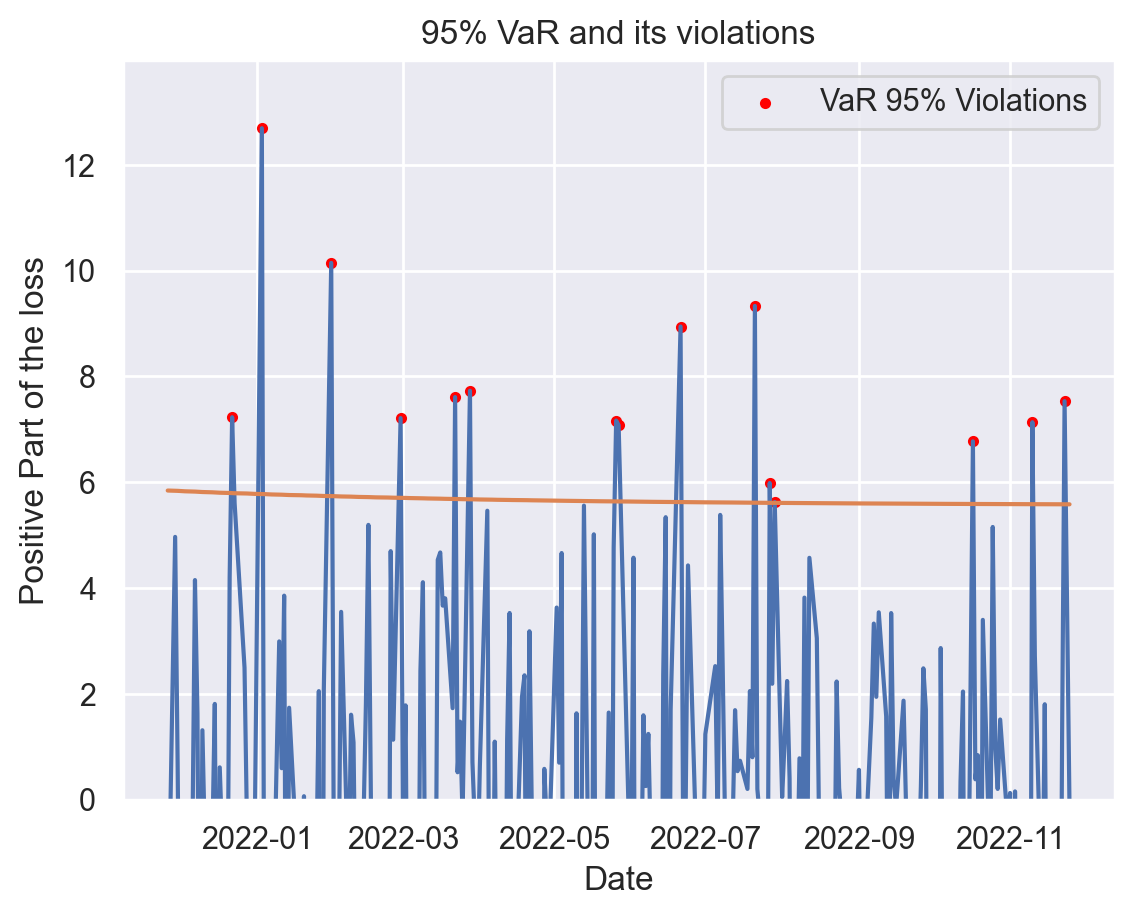

In [339]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95GPD'])
plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95GPD']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations')
plt.show()
